# Pandas 데모 - Explarotary Data Analysis

## 라이브러리 import 및 설정

In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [97]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [56]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler # 데이터 표준화

# lightgbm 모델
from lightgbm import LGBMClassifier, plot_importance

# normalization
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#feature Selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import itertools

In [57]:
rcParams['figure.figsize'] = (18, 9)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 데이터 다운로드

데이터는 [Dacon 단국대 소/중 데이터 분석 AI 경진대회 웹사이트](https://www.dacon.io/competitions/official/235638/data/)에서 다운로드 받아 `../input` 폴더에 저장.

In [58]:
!ls -alF ../../input/

total 287952
drwxr-xr-x 2 swcu swcu      4096  9월 23 11:38 ./
drwxrwxr-x 8 swcu swcu      4096  9월 24 17:19 ../
-rw-r--r-- 1 swcu swcu  47899736  9월 18 02:22 ecminer_standard_normal_outlier_train.csv
-rw-r--r-- 1 swcu swcu 132585197  9월 24 15:52 feature.csv
-rw-r--r-- 1 swcu swcu    720009  9월 23 11:34 lgbm_u_r_i_z_redshift_du_dg_dr_di_dz.csv
-rw-r--r-- 1 swcu swcu    800010  7월 26 13:35 sample_submission.csv
-rw-r--r-- 1 swcu swcu  17619545  9월 18 01:17 standard_normal_test.xlsx
-rw-r--r-- 1 swcu swcu  18936246  7월 26 13:35 test.csv
-rw-r--r-- 1 swcu swcu  76278443  7월 26 13:35 train.csv


In [59]:
data_dir = Path('../../input/')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_dir = Path('../../sub')
target_col = 'class'
seed = 42

In [60]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

#feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

## EDA

In [61]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


## 데이터 개요

In [62]:
trn.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [63]:
trn.dtypes

u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
dered_u      float64
dered_g      float64
dered_r      float64
dered_i      float64
dered_z      float64
nObserve       int64
nDetect        int64
airmass_u    float64
airmass_g    float64
airmass_r    float64
airmass_i    float64
airmass_z    float64
class          int64
dtype: object

In [64]:
for i in trn.columns:
    print(i, len(trn.loc[trn[i]<0]))


u 3
g 4
r 0
i 4
z 9
redshift 70876
dered_u 8
dered_g 9
dered_r 6
dered_i 7
dered_z 8
nObserve 0
nDetect 0
airmass_u 0
airmass_g 0
airmass_r 0
airmass_i 0
airmass_z 0
class 0


In [65]:
col = ['u', 'g', 'r', 'i', 'z', 'dered_u', 'dered_g', 
      'dered_r', 'dered_i', 'dered_z']
trn1 = trn.copy()
for i in col:
    trn1 = trn1[trn1[i] >=0]

trn1

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,2,2,1.0930,1.0888,1.0973,1.0951,1.0909,2
319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,2,2,1.0517,1.0508,1.0526,1.0522,1.0513,1
319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,31,30,1.1933,1.1941,1.1925,1.1929,1.1937,0


In [66]:
trn1.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,3.1998e+05,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000,319978.0000
mean,19.8528,18.4320,17.7358,17.3043,17.0613,5.8309e-02,19.6301,18.2593,17.6161,17.2154,16.9947,6.3328,6.1390,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9428,1.6591,1.4662,1.3198,1.3333,5.7548e-01,1.9072,1.6566,1.4665,1.3249,1.3233,8.8814,8.5519,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,2.2651,1.2383,7.7314,2.7492,5.1281,-1.6605e+02,0.7538,3.0828,6.0403,6.8561,7.2567,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2890,3.5580e-05,18.5637,17.3484,16.7873,16.4531,16.2342,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4195,18.1405,17.5258,17.1498,16.9177,4.7133e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4320,19.0729,18.4281,18.0075,17.7290,9.4600e-02,20.1976,18.8885,18.2912,17.9070,17.6556,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


u


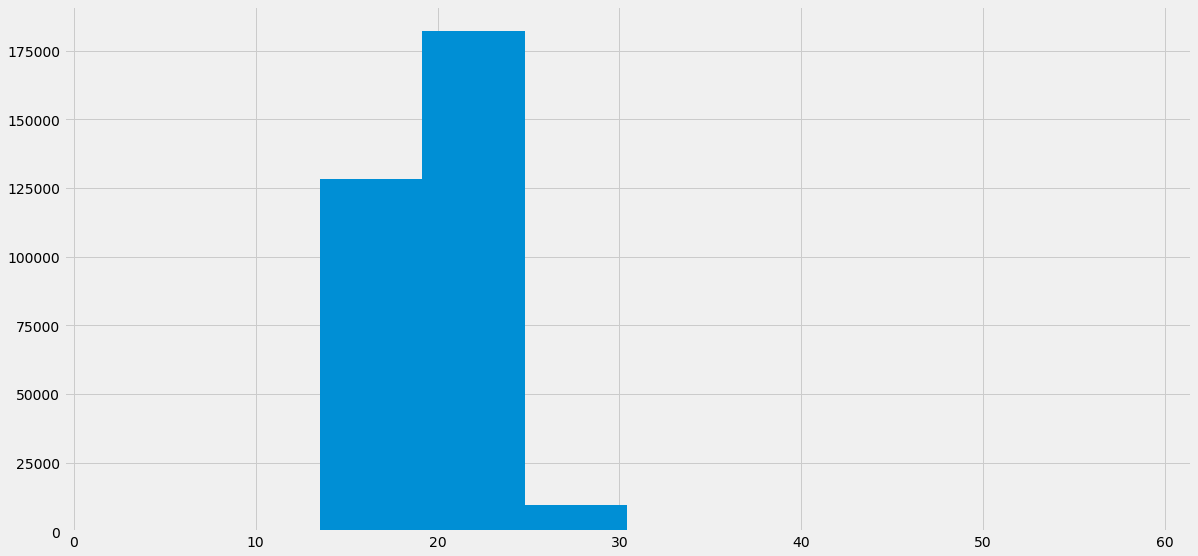

g


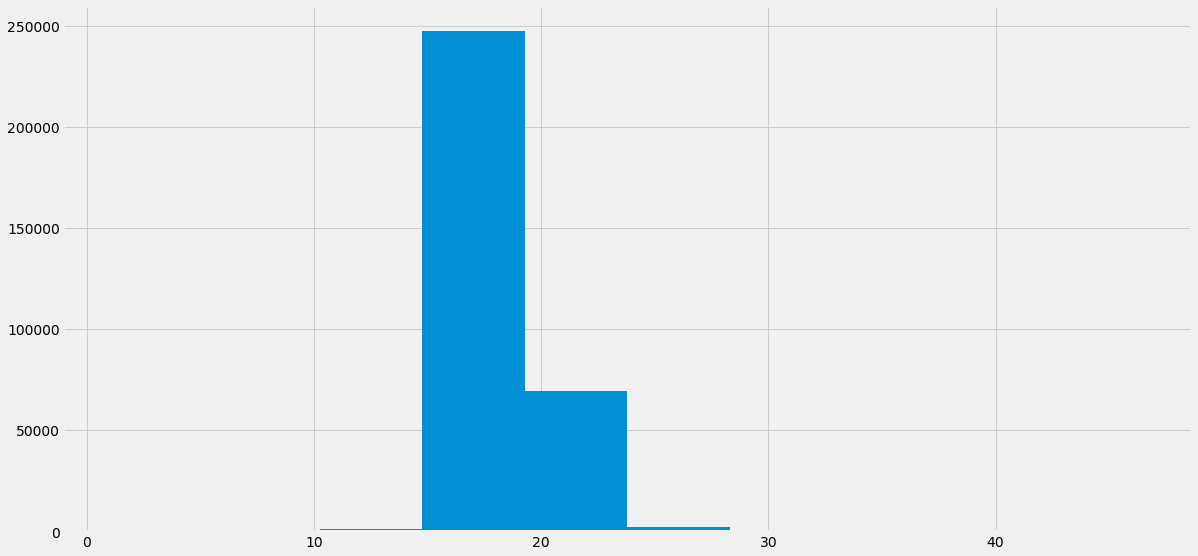

r


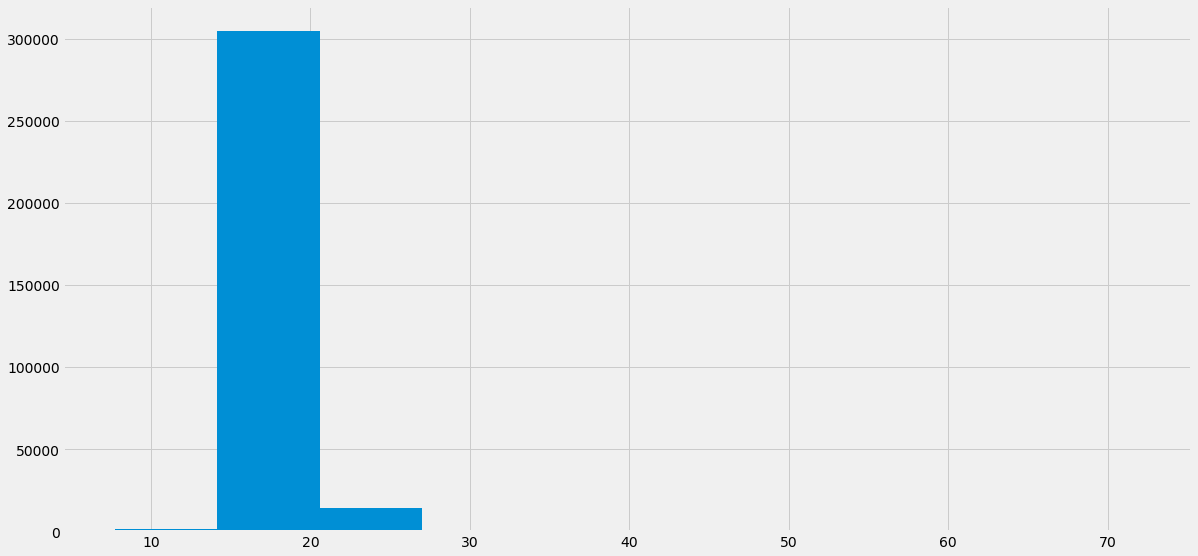

i


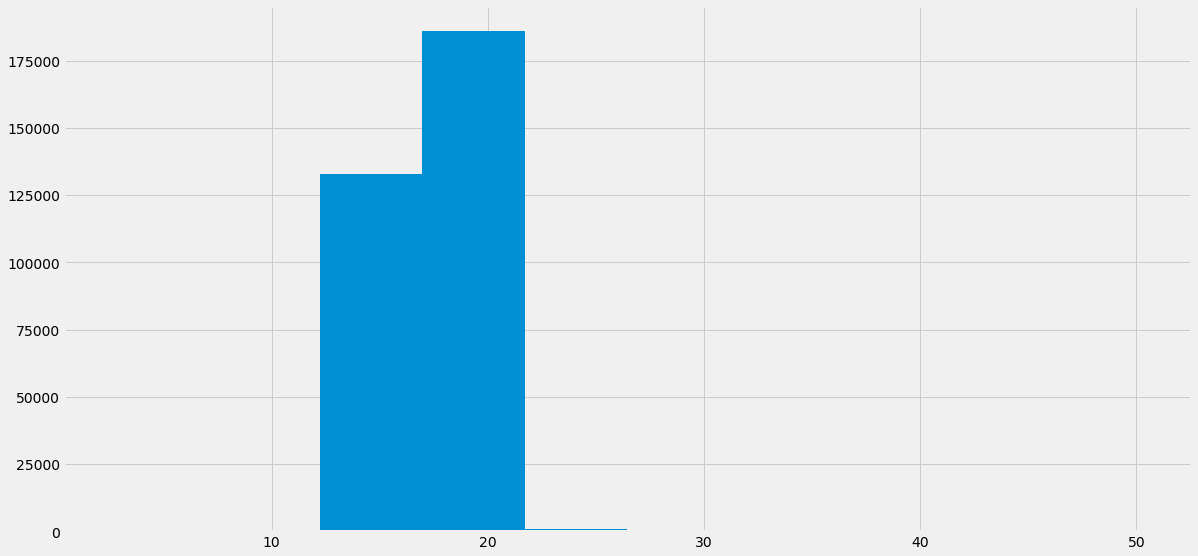

z


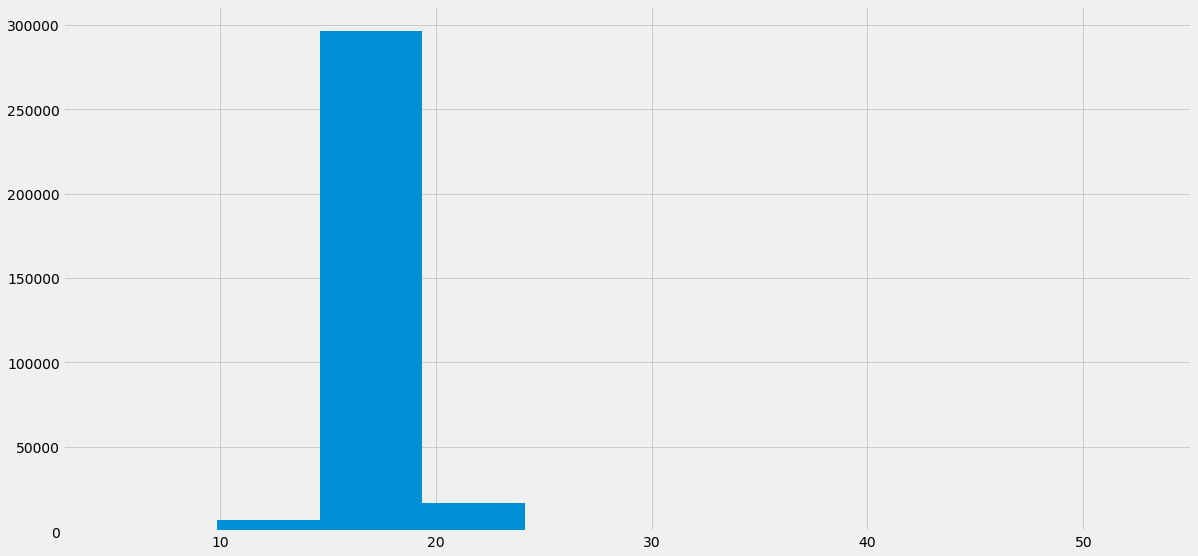

redshift


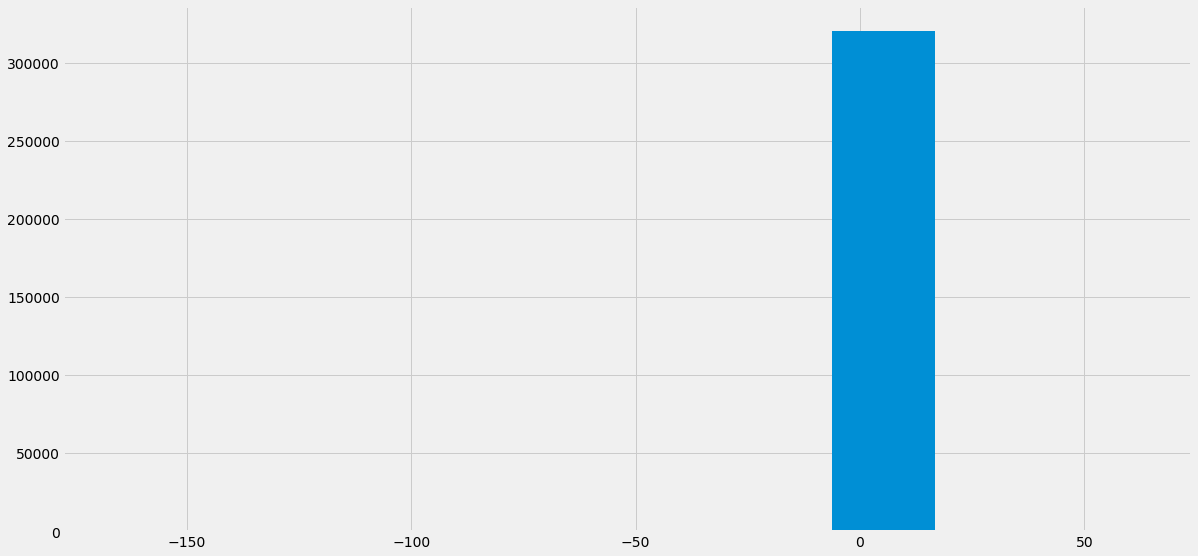

dered_u


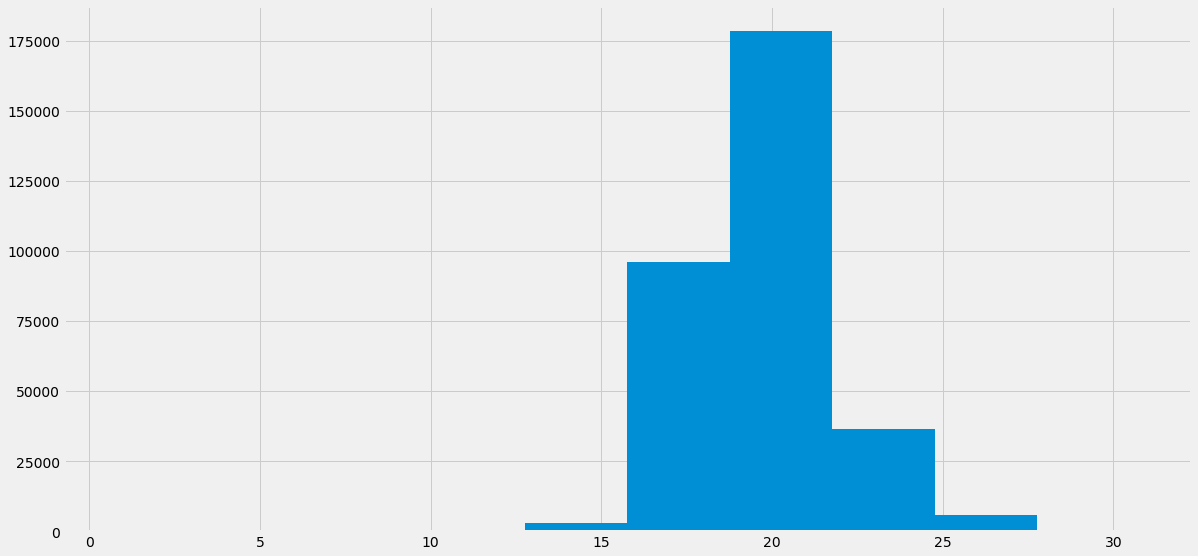

dered_g


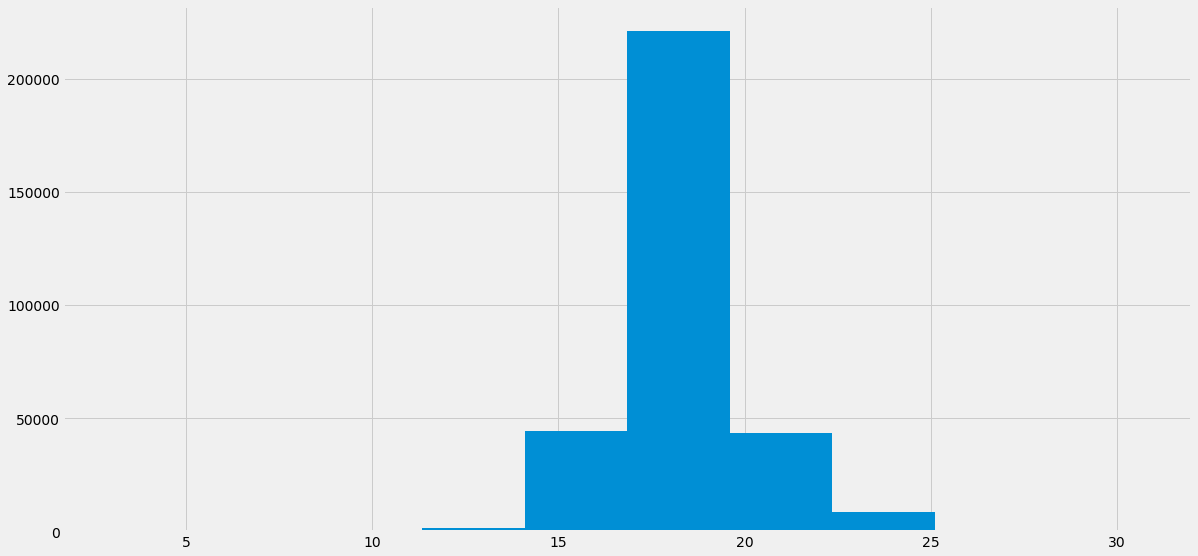

dered_r


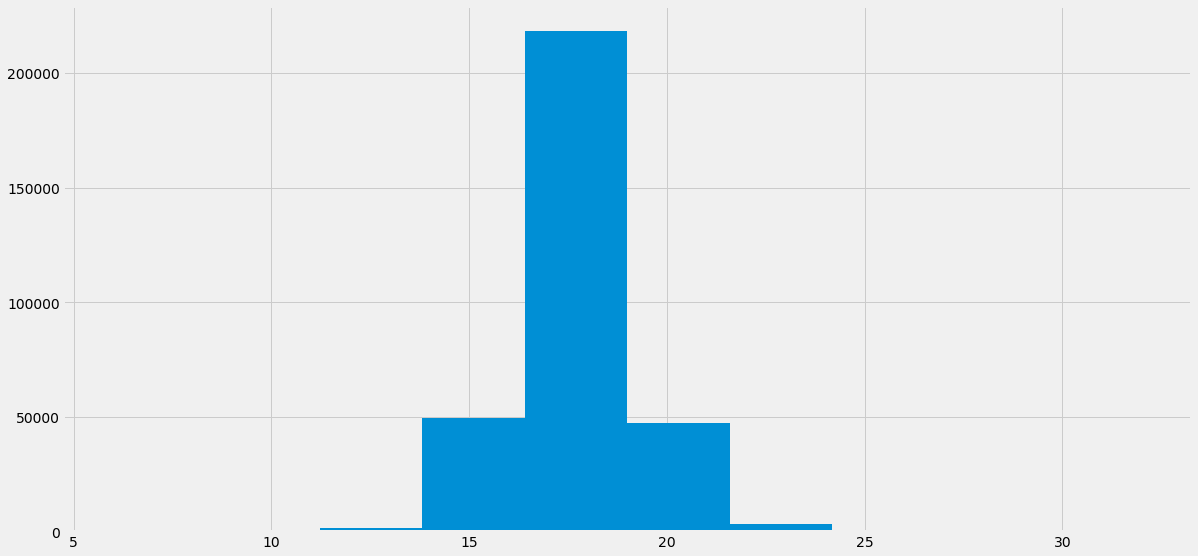

dered_i


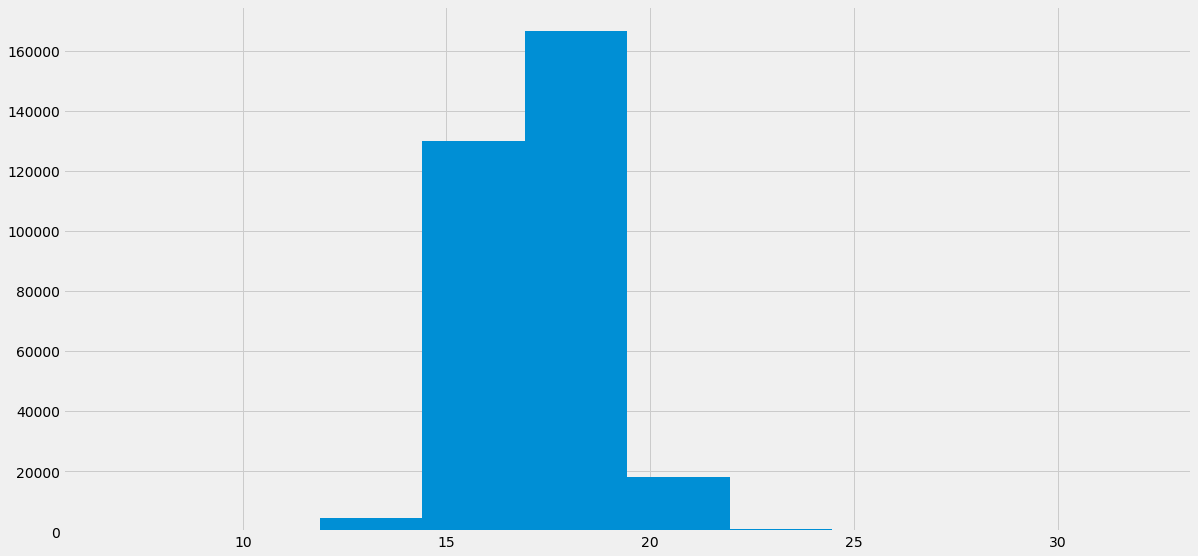

dered_z


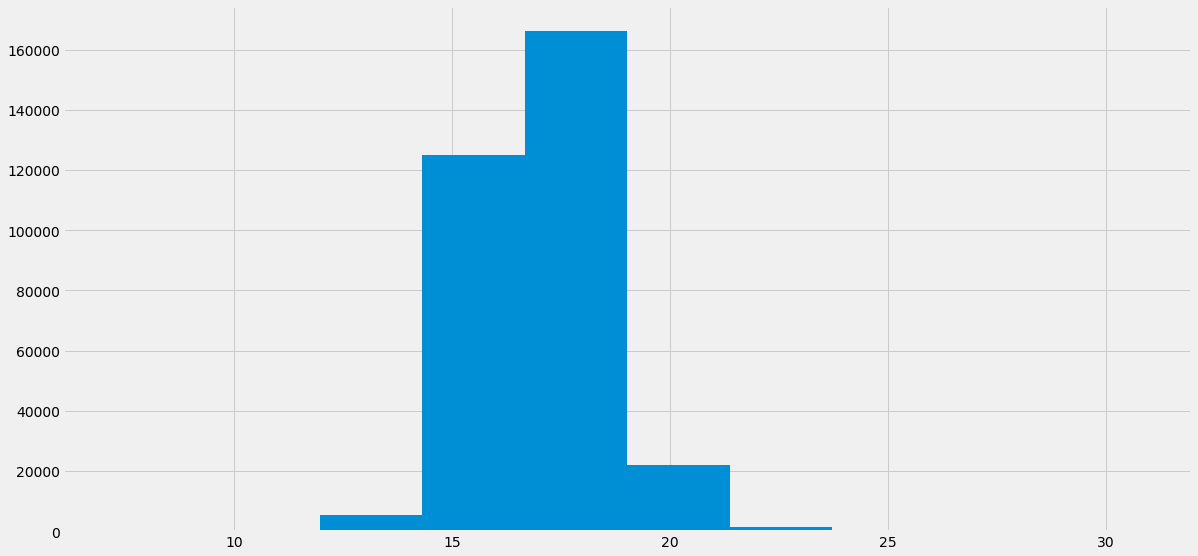

nObserve


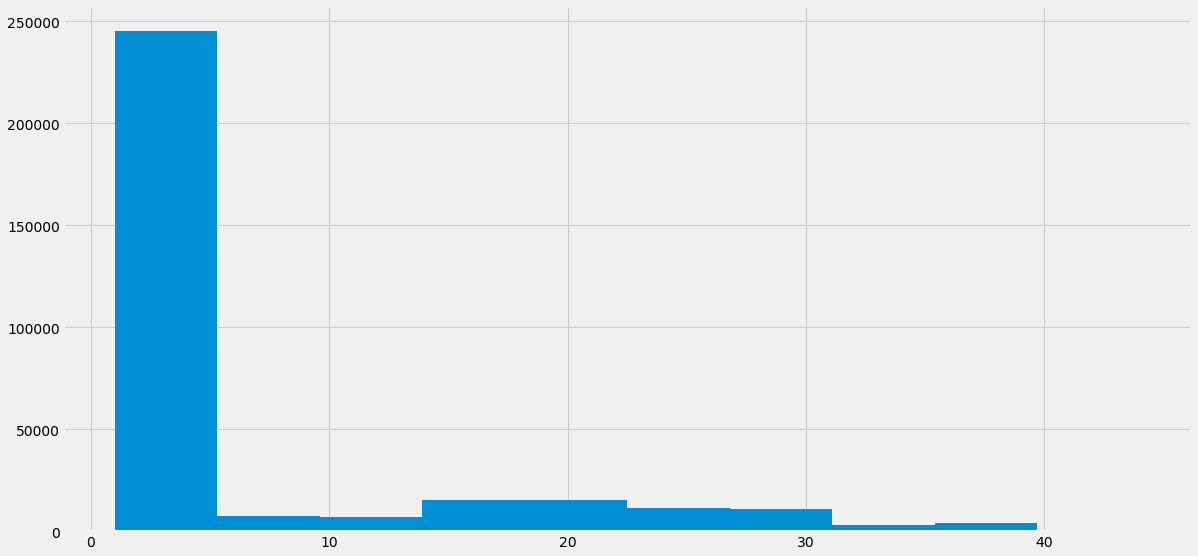

nDetect


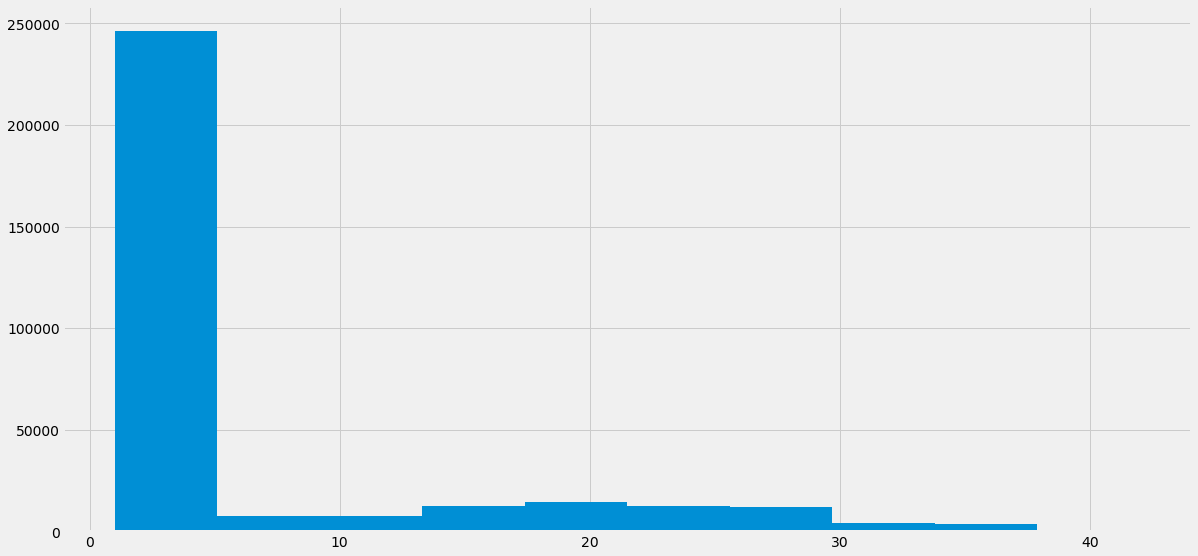

airmass_u


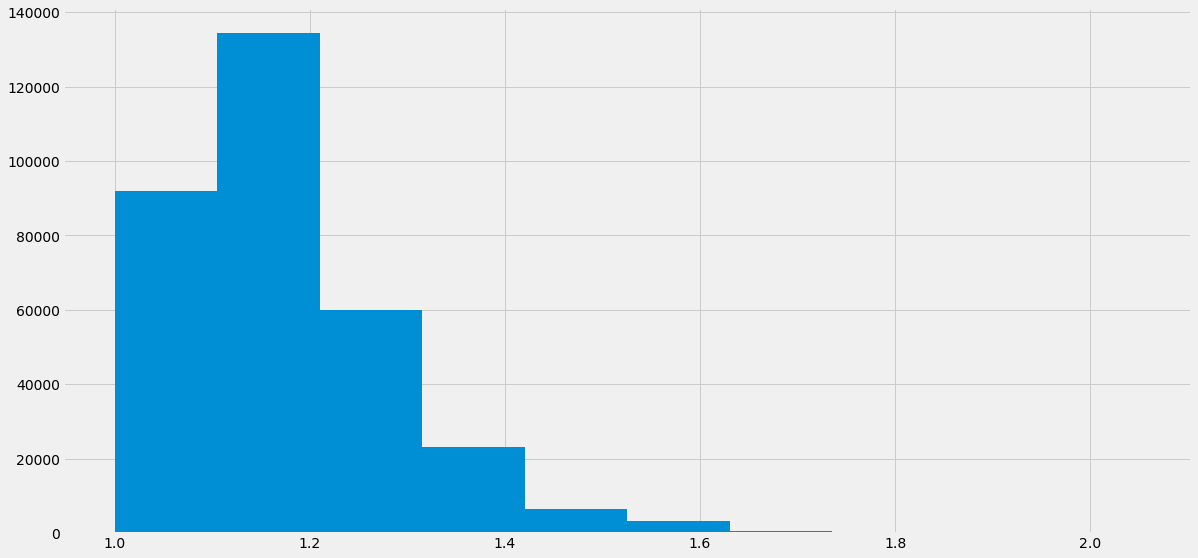

airmass_g


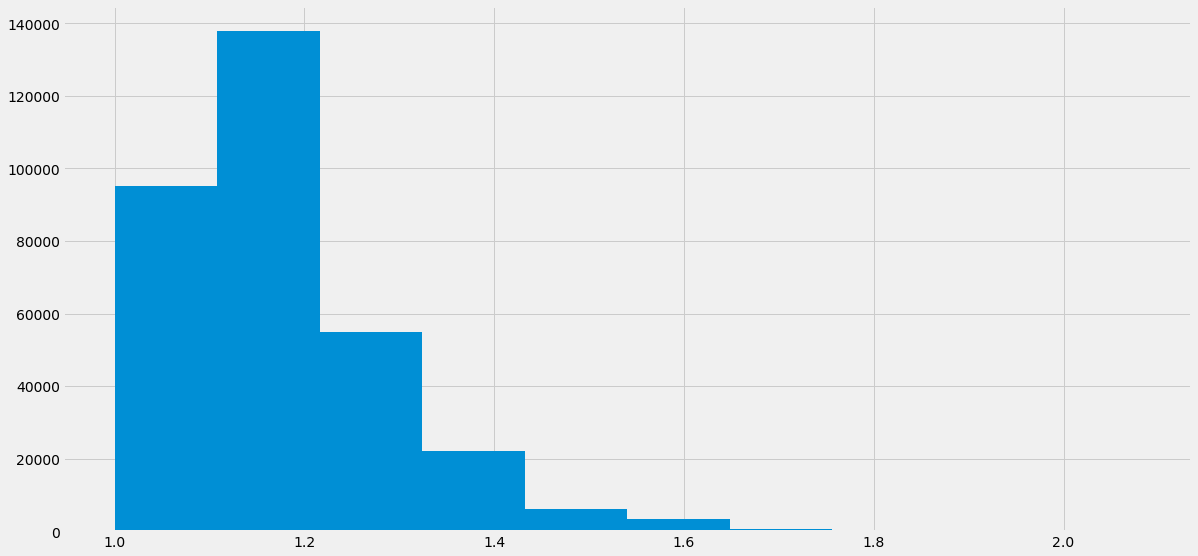

airmass_r


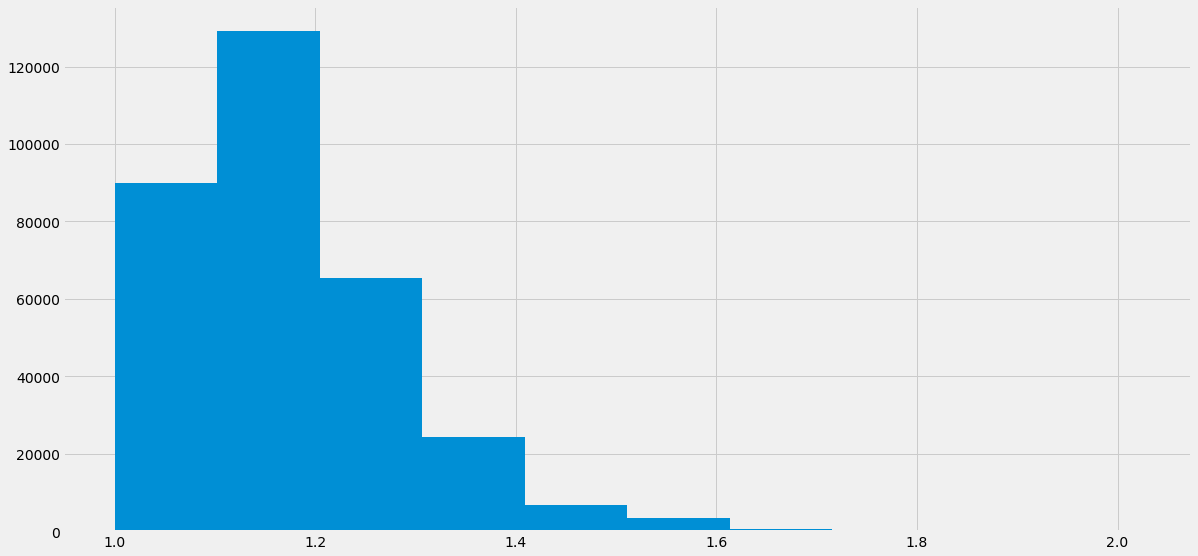

airmass_i


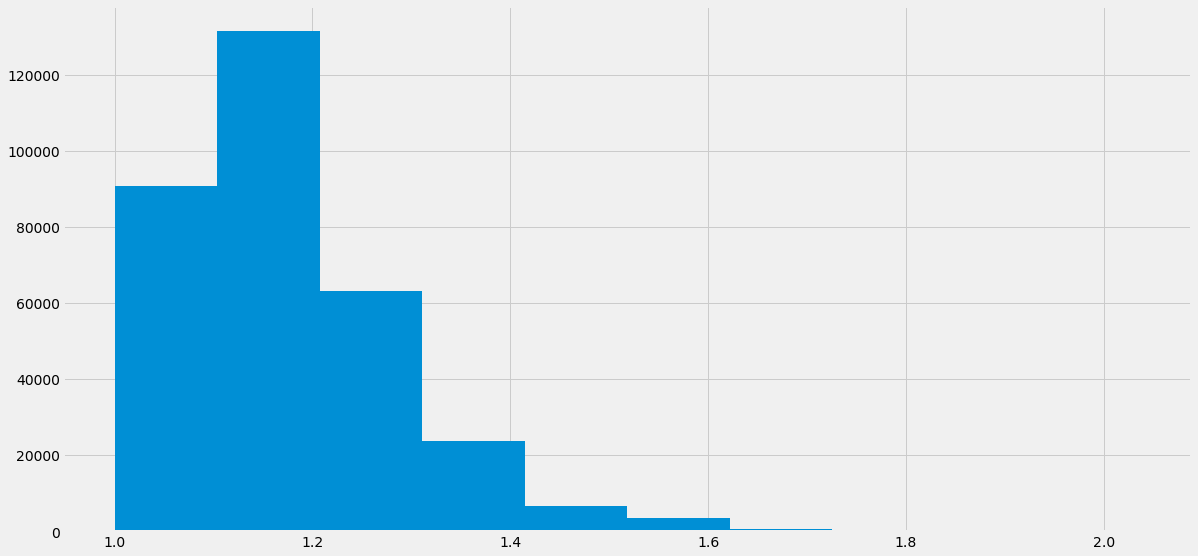

airmass_z


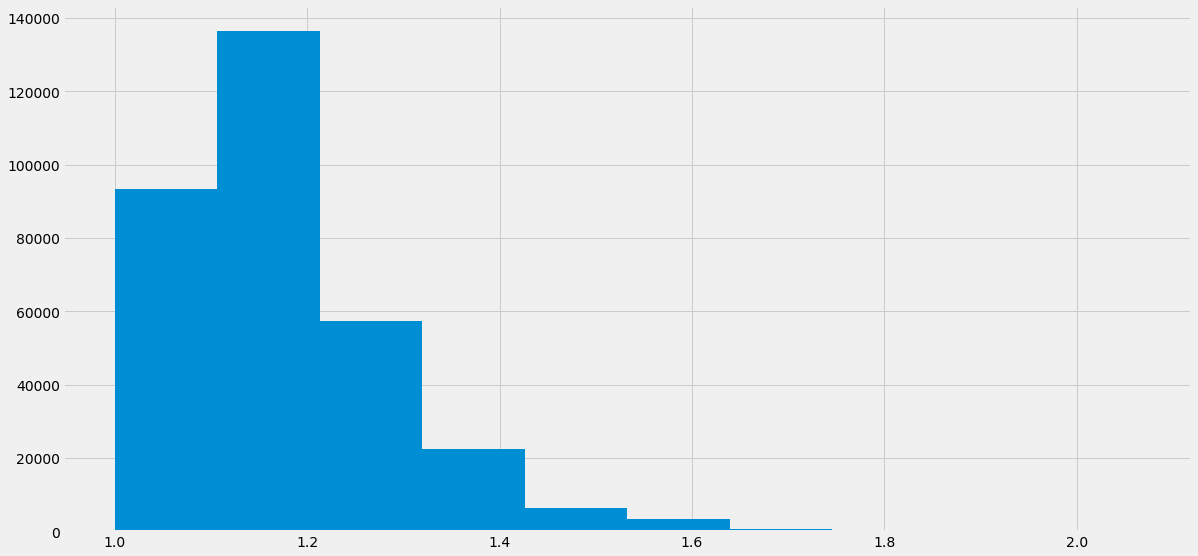

class


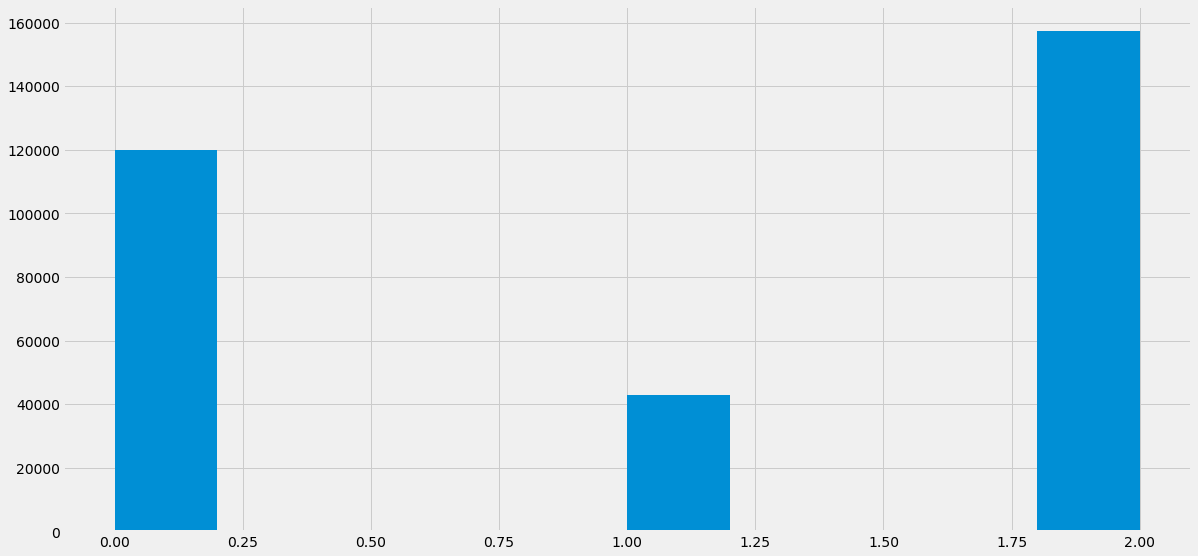

In [67]:
for i in trn1.columns:
    print(i)
    trn1[i].hist()
    plt.show()


In [68]:
tst = pd.read_csv(tst_file, index_col = 0)
tst

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885


In [69]:
df = pd.concat([trn1, tst])
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN


# Feature Engineering

In [70]:
target_col = 'class'
feature_col = [x for x in trn1.columns if trn1[x].dtype in [np.int64, np.float64] and x !=target_col]
len(feature_col)

18

In [71]:
oneChar_col = ['u','g','r','i','z']
dered_col = [c for c in df.columns if c.find('dered') != -1]
airmass_col = [c for c in df.columns if c.find('airmass') != -1]
print(dered_col)
print(airmass_col)

['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']
['airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z']


In [72]:
# #dered - 한자리
# df['d_dered_u'] = df['dered_u'] - df['u']
# df['d_dered_g'] = df['dered_g'] - df['g']
# df['d_dered_r'] = df['dered_r'] - df['r']
# df['d_dered_i'] = df['dered_i'] - df['i']
# df['d_dered_z'] = df['dered_z'] - df['z']
# df['dered_ur'] = df['dered_u'] - df['r']
# df['dered_gi'] = df['dered_g'] - df['i']
# df['dered_gz'] = df['dered_g'] - df['z']
# df['dered_ru'] = df['dered_r'] - df['u']
# df['dered_ig'] = df['dered_i'] - df['g']
# df['dered_iz'] = df['dered_i'] - df['z']
# df['dered_zi'] = df['dered_z'] - df['i']

# #dered - dered
# df['d_dered_ur'] = df['dered_u'] - df['dered_r']
# df['d_dered_rg'] = df['dered_r'] - df['dered_g']
# df['d_dered_ig'] = df['dered_i'] - df['dered_g']
# df['d_dered_zg'] = df['dered_z'] - df['dered_g']
# df['d_dered_ri'] = df['dered_r'] - df['dered_i']
# df['d_dered_rz'] = df['dered_r'] - df['dered_z']
# df['d_dered_iz'] = df['dered_i'] - df['dered_z']
# df['d_obs_det'] = df['nObserve'] - df['nDetect']

# # airmass 끼리
# df['air_ug'] = df['airmass_u'] - df['airmass_g']
# df['air_ur'] = df['airmass_u'] - df['airmass_r']
# df['air_ui'] = df['airmass_u'] - df['airmass_i']
# df['air_uz'] = df['airmass_u'] - df['airmass_z']
# df['air_gr'] = df['airmass_g'] - df['airmass_r']
# df['air_gi'] = df['airmass_g'] - df['airmass_i']
# df['air_gz'] = df['airmass_g'] - df['airmass_z']
# df['air_ri'] = df['airmass_r'] - df['airmass_i']
# df['air_rz'] = df['airmass_r'] - df['airmass_z']
# df['air_iz'] = df['airmass_i'] - df['airmass_z']

# #한자리 끼리
# df['ur'] = df['u'] - df['r']
# df['ug'] = df['u'] - df['g']
# df['gi'] = df['g'] - df['i']
# df['gz'] = df['g'] - df['z']
# df['iz'] = df['i'] - df['z']


#모든 조합 차이 feature
diff_feature = []
for c1, c2 in itertools.combinations(feature_col,2):
    new_c = f'{c1}_{c2}_diff'
    df[new_c] = df[c1] - df[c2]
    diff_feature.append(new_c)
#모든 조합 나누기    
divide_feature = []
for c1, c2 in itertools.combinations(feature_col,2):
    new_c = f'{c1}_{c2}_divide'
    df[new_c] = df[c1] / df[c2]
    divide_feature.append(new_c)
# 
df.columns.shape

(325,)

In [73]:
df

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,...,dered_g_airmass_u_divide,dered_g_airmass_g_divide,dered_g_airmass_r_divide,dered_g_airmass_i_divide,dered_g_airmass_z_divide,dered_r_dered_i_divide,dered_r_dered_z_divide,dered_r_nObserve_divide,dered_r_nDetect_divide,dered_r_airmass_u_divide,dered_r_airmass_g_divide,dered_r_airmass_r_divide,dered_r_airmass_i_divide,dered_r_airmass_z_divide,dered_i_dered_z_divide,dered_i_nObserve_divide,dered_i_nDetect_divide,dered_i_airmass_u_divide,dered_i_airmass_g_divide,dered_i_airmass_r_divide,dered_i_airmass_i_divide,dered_i_airmass_z_divide,dered_z_nObserve_divide,dered_z_nDetect_divide,dered_z_airmass_u_divide,dered_z_airmass_g_divide,dered_z_airmass_r_divide,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,2.9272,4.2545,5.5915,6.3243,23.2640,0.1397,3.0062,4.3088,5.6318,6.3550,5.2640,5.2640,22.0742,22.0733,22.0750,22.0746,22.0738,1.3273,2.6643,3.3972,20.3369,-2.7875,0.0790,1.3817,2.7047,3.4278,2.3368,2.3368,19.1470,19.1461,19.1478,...,17.0267,17.0136,17.0380,17.0326,17.0204,1.0750,1.1210,1.0531,1.0531,15.9318,15.9196,15.9424,15.9373,15.9259,1.0428,0.9796,0.9796,14.8198,14.8084,14.8296,14.8249,14.8143,0.9394,0.9394,14.2120,14.2011,14.2214,14.2169,14.2067,1.0000,15.1291,15.1174,15.1390,15.1343,15.1234,15.1291,15.1174,15.1390,15.1343,15.1234,0.9992,1.0007,1.0003,0.9996,1.0014,1.0011,1.0004,0.9997,0.9990,0.9993
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,0.9902,1.5997,1.7837,1.8832,15.0476,0.0857,1.0476,1.6408,1.8159,1.9175,14.0521,14.0521,13.7989,13.7943,13.8034,13.8012,13.7966,0.6096,0.7935,0.8930,14.0575,-0.9045,0.0574,0.6506,0.8257,0.9273,13.0620,13.0620,12.8087,12.8041,12.8132,...,11.1745,11.1338,11.2147,11.1947,11.1542,1.0132,1.0211,13.4114,13.4114,10.7013,10.6623,10.7397,10.7206,10.6818,1.0077,13.2363,13.2363,10.5615,10.5230,10.5995,10.5806,10.5423,13.1347,13.1347,10.4805,10.4423,10.5182,10.4994,10.4614,1.0000,0.7979,0.7950,0.8008,0.7994,0.7965,0.7979,0.7950,0.8008,0.7994,0.7965,0.9964,1.0036,1.0018,0.9982,1.0073,1.0055,1.0018,0.9982,0.9946,0.9964
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,0.9610,1.2501,1.3928,1.4364,16.7859,0.1787,1.0998,1.3463,1.4647,1.4903,14.7864,14.7864,15.7639,15.7623,15.7654,15.7647,15.7631,0.2891,0.4319,0.4754,15.8250,-0.7822,0.1388,0.3854,0.5037,0.5293,13.8254,13.8254,14.8029,14.8013,14.8044,...,15.3414,15.3174,15.3642,15.3530,15.3295,1.0077,1.0094,7.7200,7.7200,15.1003,15.0766,15.1227,15.1117,15.0886,1.0017,7.6609,7.6609,14.9846,14.9611,15.0068,14.9959,14.9730,7.6480,7.6480,14.

In [74]:
# zip 함수를 이용한 row별, 시리즈 그룹별 max, min, max-min, std, sum 을 feature로 생성
# 그 외에도 mean, skew 등을 사용해 볼 수도 있긴 함 

for prefix, g in zip(['one','dered','airmass'], [oneChar_col, dered_col, airmass_col]):
    
    df[f'{prefix}_max'] = df[g].max(axis=1)
    
    df[f'{prefix}_min'] = df[g].min(axis=1)
    
    df[f'{prefix}_diff'] = df[f'{prefix}_max'] - df[f'{prefix}_min']
    
    df[f'{prefix}_std'] = df[g].std(axis=1)
    
    df[f'{prefix}_sum'] = df[g].sum(axis=1)
    
    

In [75]:
# 각 그룹별 max-max, min-min, sum-sum, std-std을 feature로 생성

for c in itertools.combinations(['one','dered','airmass'],2):
    df[f'{c[0]}_{c[1]}_max_diff'] = df[f'{c[0]}_max'] - df[f'{c[1]}_max']
    
    df[f'{c[0]}_{c[1]}_min_diff'] = df[f'{c[0]}_min'] - df[f'{c[1]}_min']
    
    df[f'{c[0]}_{c[1]}_sum_diff'] = df[f'{c[0]}_sum'] - df[f'{c[1]}_sum']
    
    df[f'{c[0]}_{c[1]}_std_diff'] = df[f'{c[0]}_std'] - df[f'{c[1]}_std']

## Permutation Importance (쓸만한 feature 골라내기)

In [76]:
df.head()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,...,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,2.9272,4.2545,5.5915,6.3243,23.2640,0.1397,3.0062,4.3088,5.6318,6.3550,5.2640,5.2640,22.0742,22.0733,22.0750,22.0746,22.0738,1.3273,2.6643,3.3972,20.3369,-2.7875,0.0790,1.3817,2.7047,3.4278,2.3368,2.3368,19.1470,19.1461,19.1478,...,14.2169,14.2067,1.0000,15.1291,15.1174,15.1390,15.1343,15.1234,15.1291,15.1174,15.1390,15.1343,15.1234,0.9992,1.0007,1.0003,0.9996,1.0014,1.0011,1.0004,0.9997,0.9990,0.9993,23.2640,16.9396,6.3243,2.4994,97.2223,23.1243,16.9089,6.2153,2.4562,96.8782,1.1907,1.1890,0.0017,0.0007,5.9490,0.1397,0.0307,0.3441,0.0432,22.0733,15.7506,91.2733,2.4987,21.9336,15.7200,90.9292,2.4555
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,0.9902,1.5997,1.7837,1.8832,15.0476,0.0857,1.0476,1.6408,1.8159,1.9175,14.0521,14.0521,13.7989,13.7943,13.8034,13.8012,13.7966,0.6096,0.7935,0.8930,14.0575,-0.9045,0.0574,0.6506,0.8257,0.9273,13.0620,13.0620,12.8087,12.8041,12.8132,...,10.4994,10.4614,1.0000,0.7979,0.7950,0.8008,0.7994,0.7965,0.7979,0.7950,0.8008,0.7994,0.7965,0.9964,1.0036,1.0018,0.9982,1.0073,1.0055,1.0018,0.9982,0.9946,0.9964,15.0521,13.1689,1.8832,0.7807,69.0039,14.9664,13.1347,1.8317,0.7586,68.7533,1.2578,1.2488,0.0091,0.0036,6.2664,0.0857,0.0343,0.2507,0.0222,13.7943,11.9202,62.7375,0.7771,13.7086,11.8859,62.4869,0.7550
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,0.9610,1.2501,1.3928,1.4364,16.7859,0.1787,1.0998,1.3463,1.4647,1.4903,14.7864,14.7864,15.7639,15.7623,15.7654,15.7647,15.7631,0.2891,0.4319,0.4754,15.8250,-0.7822,0.1388,0.3854,0.5037,0.5293,13.8254,13.8254,14.8029,14.8013,14.8044,...,14.9708,14.9479,1.0000,1.9560,1.9529,1.9589,1.9575,1.9545,1.9560,1.9529,1.9589,1.9575,1.9545,0.9984,1.0015,1.0008,0.9992,1.0031,1.0023,1.0008,0.9993,0.9977,0.9985,16.7864,15.3500,1.4364,0.5934,78.8917,16.6076,15.2961,1.3116,0.5462,78.3521,1.0241,1.0210,0.0031,0.0012,5.1126,0.1787,0.0540,0.5396,0.0472,15.7623,14.3290,73.7791,0.5922,15.5835,14.2751,73.2395,0.5450
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,

In [77]:
# 첨도부분 처리
df['airmass_g'] = np.sqrt(np.log(df['airmass_g']))
df['airmass_i'] = np.sqrt(np.log(df['airmass_i']))
df['airmass_r'] = np.sqrt(np.log(df['airmass_r']))
#Train_copy1['airmass_r'] = np.log(Train_copy1['airmass_r'])
#Train_copy1['airmass_u'] = np.log1p(np.log1p(Train_copy1['airmass_u']))
#Train_copy1['airmass_z'] = np.log1p(np.log1p(Train_copy1['airmass_z']))
df['airmass_u'] = np.sqrt(np.log(df['airmass_u']))
df['airmass_z'] = np.sqrt(np.log(df['airmass_z']))

#Train_copy1['nDetect'] = np.log(Train_copy1['nDetect'])
df['nDetect'] = np.log(df['nDetect'])
#Train_copy1['nObserve'] = np.log1p(Train_copy1['nObserve']) #sqrt ,cbrt
df['nObserve'] = np.log(df['nObserve'])

df['r'] = np.log(df['r'])
df['u'] = np.log(df['u'])
df['g'] = np.log(df['g'])
df['i'] = np.log(df['i'])
df['z'] = np.log(df['z'])

df['dered_r'] = np.sqrt(np.log(df['dered_r']))
df['dered_i'] = np.sqrt(np.log(df['dered_i']))
df['dered_u'] = np.sqrt(np.log(df['dered_u']))
df['dered_g'] = np.sqrt(np.log(df['dered_g']))
df['dered_z'] = np.sqrt(np.log(df['dered_z']))


In [78]:
Y = df['class']
X = df.drop(['class'], axis = 1)
X

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.1469,3.0124,2.9449,2.8720,2.8297,-8.1086e-05,1.7723,1.7345,1.7152,1.6940,1.6816,2.8904,2.8904,0.4168,0.4178,0.4160,0.4164,0.4173,2.9272,4.2545,5.5915,6.3243,23.2640,0.1397,3.0062,4.3088,5.6318,6.3550,5.2640,5.2640,22.0742,22.0733,22.0750,22.0746,22.0738,1.3273,2.6643,3.3972,20.3369,-2.7875,0.0790,1.3817,2.7047,3.4278,2.3368,2.3368,19.1470,19.1461,19.1478,19.1474,...,14.2169,14.2067,1.0000,15.1291,15.1174,15.1390,15.1343,15.1234,15.1291,15.1174,15.1390,15.1343,15.1234,0.9992,1.0007,1.0003,0.9996,1.0014,1.0011,1.0004,0.9997,0.9990,0.9993,23.2640,16.9396,6.3243,2.4994,97.2223,23.1243,16.9089,6.2153,2.4562,96.8782,1.1907,1.1890,1.7020e-03,6.7348e-04,5.9490,0.1397,0.0307,0.3441,0.0432,22.0733,15.7506,91.2733,2.4987,21.9336,15.7200,90.9292,2.4555
1,2.7115,2.6435,2.5992,2.5854,2.5779,4.5061e-03,1.6449,1.6246,1.6112,1.6072,1.6048,0.0000,0.0000,0.4751,0.4789,0.4713,0.4732,0.4770,0.9902,1.5997,1.7837,1.8832,15.0476,0.0857,1.0476,1.6408,1.8159,1.9175,14.0521,14.0521,13.7989,13.7943,13.8034,13.8012,13.7966,0.6096,0.7935,0.8930,14.0575,-0.9045,0.0574,0.6506,0.8257,0.9273,13.0620,13.0620,12.8087,12.8041,12.8132,12.8110,...,10.4994,10.4614,1.0000,0.7979,0.7950,0.8008,0.7994,0.7965,0.7979,0.7950,0.8008,0.7994,0.7965,0.9964,1.0036,1.0018,0.9982,1.0073,1.0055,1.0018,0.9982,0.9946,0.9964,15.0521,13.1689,1.8832,0.7807,69.0039,14.9664,13.1347,1.8317,0.7586,68.7533,1.2578,1.2488,9.0740e-03,3.5867e-03,6.2664,0.0857,0.0343,0.2507,0.0222,13.7943,11.9202,62.7375,0.7771,13.7086,11.8859,62.4869,0.7550
2,2.8206,2.7616,2.7432,2.7339,2.7311,4.7198e-04,1.6763,1.6592,1.6544,1.6521,1.6515,0.6931,0.6931,0.1492,0.1543,0.1441,0.1466,0.1517,0.9610,1.2501,1.3928,1.4364,16.7859,0.1787,1.0998,1.3463,1.4647,1.4903,14.7864,14.7864,15.7639,15.7623,15.7654,15.7647,15.7631,0.2891,0.4319,0.4754,15.8250,-0.7822,0.1388,0.3854,0.5037,0.5293,13.8254,13.8254,14.8029,14.8013,14.8044,14.8037,...,14.9708,14.9479,1.0000,1.9560,1.9529,1.9589,1.9575,1.9545,1.9560,1.9529,1.9589,1.9575,1.9545,0.9984,1.0015,1.0008,0.9992,1.0031,1.0023,1.0008,0.9993,0.9977,0.9985,16.7864,15.3500,1.4364,0.5934,78.8917,16.6076,15.2961,1.3116,0.5462,78.3521,1.0241,1.0210,3.1220e-03,1.2343e-03,5.1126,0.1787,0.0540,0.5396,0.0472,15.7623,14.3290,73.7791,0.5922,15.5835,14.2751,73.2395,0.5450
3,3.2450,3.0535,3.0067,2.9905,2.9773,5.8143e-06,1.

# 표준화 및 정규화 , 이상치제거

In [79]:
# 표준화 : RobustScaler() :
# 이상치, 특이값에 덜 민감한" 중앙값(median)과 IQR(Inter-Quartile Range)을 이용해서 척도를 표준화하는 방법
#  (x-median)/IQR )

x_RobustScaler = RobustScaler().fit_transform(X)
X = pd.DataFrame(x_RobustScaler, columns = X.columns)
X
#len(x_RobustScaler)

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff
0,2.0687,1.3048,0.9240,0.3484,0.0148,-0.4991,2.1350,1.3611,0.9617,0.3694,0.0274,1.3652,1.3652,0.0659,0.0731,0.0600,0.0627,0.0693,3.1369,2.4891,2.8871,2.8732,2.3226,0.0335,2.7694,2.3742,2.8081,2.8175,-2.9071,-2.9944,2.2590,2.2593,2.2589,2.2588,2.2592,1.6319,2.6824,2.6758,1.4310,-3.1203,-0.2211,1.4483,2.5860,2.6335,-3.3413,-3.4347,1.3783,1.3788,1.3782,1.3783,...,-0.1770,-0.1813,0.0000,4.0976,4.0944,4.1028,4.1001,4.0958,4.2549,4.2499,4.2555,4.2536,4.2519,-0.0344,0.0241,0.0266,-0.0317,0.0291,0.0318,0.0370,-0.0215,-0.0266,-0.0291,2.2043,0.0200,2.8509,2.8015,1.0052,2.3095,0.0344,2.8531,2.8139,1.0519,0.0714,0.0785,-0.4212,-0.4211,0.0747,0.0449,-0.2368,-0.1270,0.1646,2.2150,0.0016,1.0083,2.8060,2.3108,0.0157,1.0550,2.8187
1,-2.9196,-2.9094,-3.0101,-2.9859,-2.9560,-0.4506,-3.0643,-3.0343,-3.1401,-3.0904,-3.0508,-0.4307,-0.4307,0.4254,0.4547,0.3965,0.4104,0.4398,-0.5391,-0.3234,-0.4233,-0.4554,-2.5381,-0.2966,-0.6161,-0.3672,-0.4482,-0.4637,-0.7099,-0.7373,-2.6376,-2.6404,-2.6350,-2.6361,-2.6389,-0.0384,-0.3039,-0.3776,-2.5139,0.3911,-0.4329,-0.1449,-0.3528,-0.3937,-0.6445,-0.6697,-2.6443,-2.6484,-2.6410,-2.6424,...,-1.9115,-1.9282,0.0000,-0.3261,-0.3268,-0.3249,-0.3255,-0.3265,-0.3294,-0.3300,-0.3286,-0.3289,-0.3296,-0.6369,0.6405,0.6399,-0.6379,0.6412,0.6403,0.6377,-0.6388,-0.6375,-0.6378,-2.5234,-2.6473,-0.4621,-0.4249,-2.5749,-2.5920,-2.6779,-0.4027,-0.3702,-2.6336,0.5449,0.5143,0.4493,0.4494,0.5300,-0.2834,-0.1658,-0.3372,-0.2910,-2.6029,-2.7463,-2.6803,-0.4267,-2.6632,-2.7715,-2.7327,-0.3719
2,-1.6702,-1.5600,-1.3715,-1.2577,-1.1478,-0.4932,-1.7849,-1.6528,-1.4390,-1.3024,-1.1771,0.0000,0.0000,-1.5852,-1.5699,-1.5949,-1.5890,-1.5773,-0.5946,-0.6938,-0.7631,-0.7903,-1.5097,0.2723,-0.5259,-0.6697,-0.7479,-0.7795,-0.5263,-0.5487,-1.4749,-1.4757,-1.4741,-1.4744,-1.4752,-0.7842,-0.8811,-0.8868,-1.4035,0.6190,0.3676,-0.7229,-0.8565,-0.8755,-0.4525,-0.4729,-1.3787,-1.3801,-1.3775,-1.3780,...,0.1748,0.1644,0.0000,0.0314,0.0306,0.0327,0.0320,0.0309,0.0411,0.0403,0.0416,0.0413,0.0407,-0.2017,0.1972,0.1983,-0.2007,0.1998,0.2009,0.2029,-0.1957,-0.1981,-0.1993,-1.5250,-1.1045,-0.7955,-0.7766,-1.3205,-1.6059,-1.1246,-0.7891,-0.7685,-1.3758,-1.1031,-1.1461,-0.2535,-0.2535,-1.1251,0.2824,0.2234,0.3131,0.2501,-1.4577,-1.0182,-1.2531,-0.7740,-1.5293,-1.0346,-1.3008,-0.7659
3,3.1921,1.7735,1.6270,1.7265,1.7567,-0.4982,3.1877,1.7718,1.6253,1.7160,1.7371,0.4307,0.2519,0.1607,0.1672,0.155

In [80]:
# 정규화
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.5104,0.6035,0.4778,0.9931,0.2842,0.3203,0.3799,0.3824,0.3458,0.0029,0.3757,0.3604,0.3995,0.3995,0.3994,0.3994,0.3995,0.4509,0.4568,0.9970,0.2983,0.5117,0.5239,0.4507,0.4567,0.0077,0.4295,0.3872,0.4916,0.4916,0.4917,0.4916,...,0.9981,0.9981,0.0012,0.4161,0.4155,0.4168,0.4165,0.4158,0.4368,0.4361,0.4375,0.4372,0.4364,0.6112,0.3858,0.3859,0.6111,0.3821,0.3826,0.3835,0.6091,0.6080,0.6100,0.0017,0.9084,8.9604e-04,7.9167e-04,0.0211,0.7204,0.9994,6.1291e-04,5.4040e-04,0.9961,0.1764,0.1849,0.0290,0.0289,0.1805,0.0016,0.0062,0.0084,0.9777,0.0018,0.9079,0.0211,7.9334e-04,0.7182,0.9994,0.9960,5.4064e-04
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.4954,0.5765,0.4272,0.9925,0.2491,0.3196,0.3495,0.3401,0.2823,0.0025,0.4805,0.4678,0.2585,0.2585,0.2586,0.2586,0.2585,0.4459,0.4438,0.9966,0.2721,0.5256,0.5238,0.4456,0.4436,0.0074,0.4967,0.4594,0.4481,0.4480,0.4481,0.4481,...,0.9976,0.9976,0.0012,0.0069,0.0070,0.0069,0.0069,0.0070,0.0074,0.0074,0.0073,0.0073,0.0074,0.4805,0.5192,0.5186,0.4796,0.5139,0.5137,0.5131,0.4746,0.4749,0.4778,0.0006,0.8581,2.5831e-04,2.3973e-04,0.0171,0.4638,0.9990,1.7514e-04,1.6126e-04,0.9933,0.2386,0.2434,0.1558,0.1557,0.2409,0.0016,0.0062,0.0084,0.9776,0.0006,0.8569,0.0171,2.4047e-04,0.4603,0.9990,0.9932,1.6085e-04
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.4951,0.5730,0.4220,0.9924,0.2565,0.3208,0.3503,0.3354,0.2765,0.0024,0.4892,0.4768,0.2920,0.2920,0.2920,0.2920,0.2920,0.4437,0.4413,0.9966,0.2795,0.5265,0.5243,0.4437,0.4413,0.0074,0.5015,0.4645,0.4618,0.4618,0.4618,0.4618,...,0.9982,0.9982,0.0012,0.0400,0.0401,0.0400,0.0400,0.0400,0.0421,0.0421,0.0420,0.0421,0.0421,0.5749,0.4233,0.4230,0.5744,0.4188,0.4190,0.4193,0.5712,0.5706,0.5730,0.0008,0.8872,1.9414e-04,1.7958e-04,0.0185,0.5155,0.9992,1.2320e-04,1.1384e-04,0.9942,0.0222,0.0205,0.0534,0.0533,0.0214,0.0016,0.0062,0.0085,0.9777,0.0009,0.8890,0.0186,1.8107e-04,0.5191,0.9992,0.9943,1.1395e-04
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.5223,0.6156,0.4801,0.9931,0.2944,0.3224,0.4057,0.4024,0.3497,0.0029,0.5712,0.5729,0.4

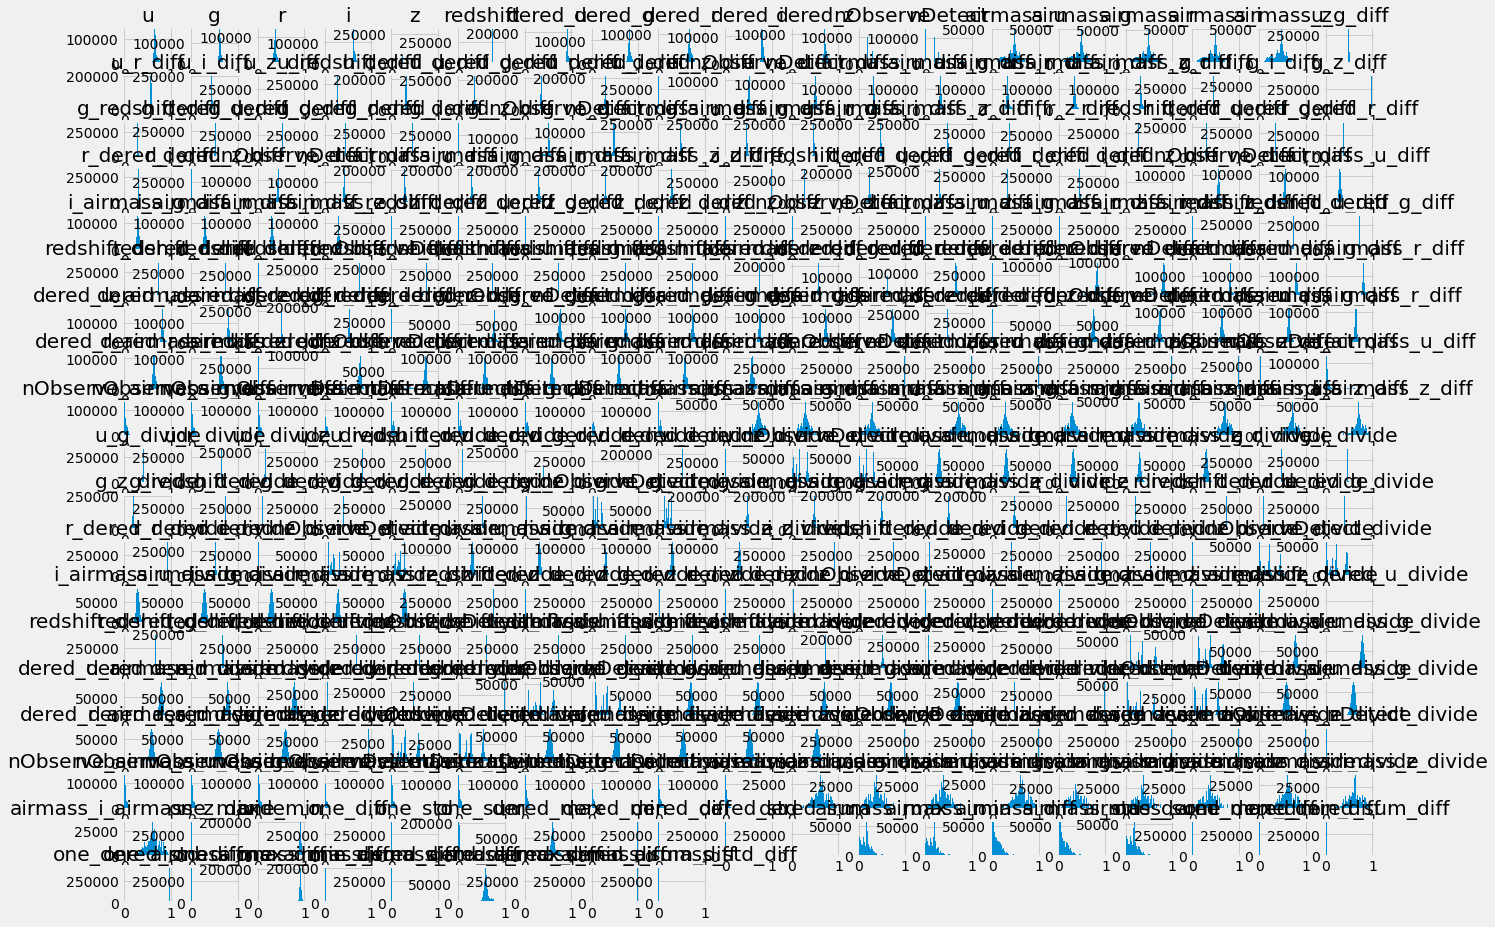

In [81]:
X.hist(bins = 50,  figsize=(20,15))
plt.show()

In [82]:
df1 = X.copy()
df1['class']= list(Y)
df1

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.5104,0.6035,0.4778,0.9931,0.2842,0.3203,0.3799,0.3824,0.3458,0.0029,0.3757,0.3604,0.3995,0.3995,0.3994,0.3994,0.3995,0.4509,0.4568,0.9970,0.2983,0.5117,0.5239,0.4507,0.4567,0.0077,0.4295,0.3872,0.4916,0.4916,0.4917,0.4916,...,0.9981,0.0012,0.4161,0.4155,0.4168,0.4165,0.4158,0.4368,0.4361,0.4375,0.4372,0.4364,0.6112,0.3858,0.3859,0.6111,0.3821,0.3826,0.3835,0.6091,0.6080,0.6100,0.0017,0.9084,8.9604e-04,7.9167e-04,0.0211,0.7204,0.9994,6.1291e-04,5.4040e-04,0.9961,0.1764,0.1849,0.0290,0.0289,0.1805,0.0016,0.0062,0.0084,0.9777,0.0018,0.9079,0.0211,7.9334e-04,0.7182,0.9994,0.9960,5.4064e-04,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.4954,0.5765,0.4272,0.9925,0.2491,0.3196,0.3495,0.3401,0.2823,0.0025,0.4805,0.4678,0.2585,0.2585,0.2586,0.2586,0.2585,0.4459,0.4438,0.9966,0.2721,0.5256,0.5238,0.4456,0.4436,0.0074,0.4967,0.4594,0.4481,0.4480,0.4481,0.4481,...,0.9976,0.0012,0.0069,0.0070,0.0069,0.0069,0.0070,0.0074,0.0074,0.0073,0.0073,0.0074,0.4805,0.5192,0.5186,0.4796,0.5139,0.5137,0.5131,0.4746,0.4749,0.4778,0.0006,0.8581,2.5831e-04,2.3973e-04,0.0171,0.4638,0.9990,1.7514e-04,1.6126e-04,0.9933,0.2386,0.2434,0.1558,0.1557,0.2409,0.0016,0.0062,0.0084,0.9776,0.0006,0.8569,0.0171,2.4047e-04,0.4603,0.9990,0.9932,1.6085e-04,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.4951,0.5730,0.4220,0.9924,0.2565,0.3208,0.3503,0.3354,0.2765,0.0024,0.4892,0.4768,0.2920,0.2920,0.2920,0.2920,0.2920,0.4437,0.4413,0.9966,0.2795,0.5265,0.5243,0.4437,0.4413,0.0074,0.5015,0.4645,0.4618,0.4618,0.4618,0.4618,...,0.9982,0.0012,0.0400,0.0401,0.0400,0.0400,0.0400,0.0421,0.0421,0.0420,0.0421,0.0421,0.5749,0.4233,0.4230,0.5744,0.4188,0.4190,0.4193,0.5712,0.5706,0.5730,0.0008,0.8872,1.9414e-04,1.7958e-04,0.0185,0.5155,0.9992,1.2320e-04,1.1384e-04,0.9942,0.0222,0.0205,0.0534,0.0533,0.0214,0.0016,0.0062,0.0085,0.9777,0.0009,0.8890,0.0186,1.8107e-04,0.5191,0.9992,0.9943,1.1395e-04,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.5223,0.6156,0.4801,0.9931,0.2944,0.3224,0.4057,0.4024,0.3497,0.0029,0.5712,0.5729,0.4400,0.4401,0.4399,0.4400,0.4

# 훈련셋과 테스트셋 나누기

In [83]:
trn2 = df1.iloc[:319978]
tst2 = df1.iloc[319978:]
tst2.drop('class', axis =1 , inplace = True)
trn2.shape, tst2.shape

((319978, 352), (80000, 351))

# outlier

In [84]:
# 전체 데이터가 아닌 각 클래스별(0,1,2)로 이상치 처리
# Train_copy1 = Train_set.copy()

def remove_outlier(data, column):
    
    print(column)
    # 클래스 0처리
    column_data_0 = data[data['class']==0][column]
    quan_25_0 = np.percentile(column_data_0.values, 0.1) # 1분위수
    quan_75_0 = np.percentile(column_data_0.values, 99.9) # 3분위수
    iqr_0 = quan_75_0 - quan_25_0 # IQR 계산
    iqr_0 *= 1.5
    lowest_0 = quan_25_0 - iqr_0 # 최솟값 설정
    highest_0 = quan_75_0 + iqr_0 # 최댓값 설정
    outlier_index_0 = column_data_0[(column_data_0 < lowest_0) | (column_data_0 > highest_0)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_0))
    
    # 클래스 1처리
    column_data_1 = data[data['class']==1][column]
    quan_25_1 = np.percentile(column_data_1.values, 0.1) # 1분위수
    quan_75_1 = np.percentile(column_data_1.values, 99.9) # 3분위수
    iqr_1 = quan_75_1 - quan_25_1 # IQR 계산
    iqr_1 *= 1.5
    lowest_1 = quan_25_1 - iqr_1 # 최솟값 설정
    highest_1 = quan_75_1 + iqr_1 # 최댓값 설정
    outlier_index_1 = column_data_1[(column_data_1 < lowest_1 )| (column_data_1 > highest_1)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_1))
    
    # 클래스 2 처리
    column_data_2 = data[data['class']==2][column]
    quan_25_2 = np.percentile(column_data_2.values, 0.1) # 1분위수
    quan_75_2 = np.percentile(column_data_2.values, 99.9) # 3분위수
    iqr_2 = quan_75_2 - quan_25_2 # IQR 계산
    iqr_2 *= 1.5
    lowest_2 = quan_25_2 - iqr_2 # 최솟값 설정
    highest_2 = quan_75_2 + iqr_2 # 최댓값 설정
    outlier_index_2 = column_data_2[(column_data_2 < lowest_2 )| (column_data_2 > highest_2)].index # 최솟값 ~ 최댓값 사이의 값만 출력
    print(len(outlier_index_2))
    # outlier 행 제거
    data.drop(list(set(list(outlier_index_0) + list(outlier_index_1) + list(outlier_index_2))), axis = 0, inplace = True)
    print(data.shape)
    return data

In [85]:
col = list(trn2.columns)
col.remove('redshift')
col.remove('class')
col

['u',
 'g',
 'r',
 'i',
 'z',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'nDetect',
 'airmass_u',
 'airmass_g',
 'airmass_r',
 'airmass_i',
 'airmass_z',
 'u_g_diff',
 'u_r_diff',
 'u_i_diff',
 'u_z_diff',
 'u_redshift_diff',
 'u_dered_u_diff',
 'u_dered_g_diff',
 'u_dered_r_diff',
 'u_dered_i_diff',
 'u_dered_z_diff',
 'u_nObserve_diff',
 'u_nDetect_diff',
 'u_airmass_u_diff',
 'u_airmass_g_diff',
 'u_airmass_r_diff',
 'u_airmass_i_diff',
 'u_airmass_z_diff',
 'g_r_diff',
 'g_i_diff',
 'g_z_diff',
 'g_redshift_diff',
 'g_dered_u_diff',
 'g_dered_g_diff',
 'g_dered_r_diff',
 'g_dered_i_diff',
 'g_dered_z_diff',
 'g_nObserve_diff',
 'g_nDetect_diff',
 'g_airmass_u_diff',
 'g_airmass_g_diff',
 'g_airmass_r_diff',
 'g_airmass_i_diff',
 'g_airmass_z_diff',
 'r_i_diff',
 'r_z_diff',
 'r_redshift_diff',
 'r_dered_u_diff',
 'r_dered_g_diff',
 'r_dered_r_diff',
 'r_dered_i_diff',
 'r_dered_z_diff',
 'r_nObserve_diff',
 'r_nDetect_diff',
 'r_airmass_u_diff',
 'r_a

In [86]:
df2 = trn2.copy()
for i in col:
    
    ROT = remove_outlier(df2, i)
    
    df2 = ROT

df2

u
2
0
2
(319974, 352)
g
1
0
0
(319973, 352)
r
0
0
1
(319972, 352)
i
1
0
0
(319971, 352)
z
0
0
0
(319971, 352)
dered_u
0
0
0
(319971, 352)
dered_g
2
0
0
(319969, 352)
dered_r
0
0
0
(319969, 352)
dered_i
0
0
0
(319969, 352)
dered_z
0
0
0
(319969, 352)
nObserve
0
0
0
(319969, 352)
nDetect
0
0
0
(319969, 352)
airmass_u
0
0
0
(319969, 352)
airmass_g
0
0
0
(319969, 352)
airmass_r
0
0
0
(319969, 352)
airmass_i
0
0
0
(319969, 352)
airmass_z
0
0
0
(319969, 352)
u_g_diff
6
5
8
(319950, 352)
u_r_diff
0
1
5
(319944, 352)
u_i_diff
2
1
1
(319940, 352)
u_z_diff
1
2
2
(319935, 352)
u_redshift_diff
24
0
0
(319911, 352)
u_dered_u_diff
0
8
16
(319887, 352)
u_dered_g_diff
0
0
0
(319887, 352)
u_dered_r_diff
0
0
0
(319887, 352)
u_dered_i_diff
0
0
0
(319887, 352)
u_dered_z_diff
0
0
0
(319887, 352)
u_nObserve_diff
0
0
0
(319887, 352)
u_nDetect_diff
0
0
0
(319887, 352)
u_airmass_u_diff
0
0
0
(319887, 352)
u_airmass_g_diff
0
0
0
(319887, 352)
u_airmass_r_diff
0
0
0
(319887, 352)
u_airmass_i_diff
0
0
0
(319887, 

0
0
(319150, 352)
i_z_divide
1
0
3
(319146, 352)
i_redshift_divide
1
0
0
(319145, 352)
i_dered_u_divide
0
0
0
(319145, 352)
i_dered_g_divide
0
0
0
(319145, 352)
i_dered_r_divide
0
4
0
(319141, 352)
i_dered_i_divide
0
0
0
(319141, 352)
i_dered_z_divide
0
0
0
(319141, 352)
i_nObserve_divide
0
0
0
(319141, 352)
i_nDetect_divide
0
0
0
(319141, 352)
i_airmass_u_divide
0
0
0
(319141, 352)
i_airmass_g_divide
0
0
0
(319141, 352)
i_airmass_r_divide
0
0
0
(319141, 352)
i_airmass_i_divide
0
0
0
(319141, 352)
i_airmass_z_divide
0
0
0
(319141, 352)
z_redshift_divide
0
1
1
(319139, 352)
z_dered_u_divide
0
0
0
(319139, 352)
z_dered_g_divide
2
0
0
(319137, 352)
z_dered_r_divide
0
4
0
(319133, 352)
z_dered_i_divide
0
4
5
(319124, 352)
z_dered_z_divide
0
1
0
(319123, 352)
z_nObserve_divide
0
0
0
(319123, 352)
z_nDetect_divide
0
0
0
(319123, 352)
z_airmass_u_divide
0
0
0
(319123, 352)
z_airmass_g_divide
0
0
0
(319123, 352)
z_airmass_r_divide
0
0
0
(319123, 352)
z_airmass_i_divide
0
0
0
(319123, 352)
z_ai

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.5104,0.6035,0.4778,0.9931,0.2842,0.3203,0.3799,0.3824,0.3458,0.0029,0.3757,0.3604,0.3995,0.3995,0.3994,0.3994,0.3995,0.4509,0.4568,0.9970,0.2983,0.5117,0.5239,0.4507,0.4567,0.0077,0.4295,0.3872,0.4916,0.4916,0.4917,0.4916,...,0.9981,0.0012,0.4161,0.4155,0.4168,0.4165,0.4158,0.4368,0.4361,0.4375,0.4372,0.4364,0.6112,0.3858,0.3859,0.6111,0.3821,0.3826,0.3835,0.6091,0.6080,0.6100,0.0017,0.9084,0.0009,0.0008,0.0211,0.7204,0.9994,0.0006,0.0005,0.9961,0.1764,0.1849,0.0290,0.0289,0.1805,0.0016,0.0062,0.0084,0.9777,0.0018,0.9079,0.0211,0.0008,0.7182,0.9994,0.9960,0.0005,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.4954,0.5765,0.4272,0.9925,0.2491,0.3196,0.3495,0.3401,0.2823,0.0025,0.4805,0.4678,0.2585,0.2585,0.2586,0.2586,0.2585,0.4459,0.4438,0.9966,0.2721,0.5256,0.5238,0.4456,0.4436,0.0074,0.4967,0.4594,0.4481,0.4480,0.4481,0.4481,...,0.9976,0.0012,0.0069,0.0070,0.0069,0.0069,0.0070,0.0074,0.0074,0.0073,0.0073,0.0074,0.4805,0.5192,0.5186,0.4796,0.5139,0.5137,0.5131,0.4746,0.4749,0.4778,0.0006,0.8581,0.0003,0.0002,0.0171,0.4638,0.9990,0.0002,0.0002,0.9933,0.2386,0.2434,0.1558,0.1557,0.2409,0.0016,0.0062,0.0084,0.9776,0.0006,0.8569,0.0171,0.0002,0.4603,0.9990,0.9932,0.0002,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.4951,0.5730,0.4220,0.9924,0.2565,0.3208,0.3503,0.3354,0.2765,0.0024,0.4892,0.4768,0.2920,0.2920,0.2920,0.2920,0.2920,0.4437,0.4413,0.9966,0.2795,0.5265,0.5243,0.4437,0.4413,0.0074,0.5015,0.4645,0.4618,0.4618,0.4618,0.4618,...,0.9982,0.0012,0.0400,0.0401,0.0400,0.0400,0.0400,0.0421,0.0421,0.0420,0.0421,0.0421,0.5749,0.4233,0.4230,0.5744,0.4188,0.4190,0.4193,0.5712,0.5706,0.5730,0.0008,0.8872,0.0002,0.0002,0.0185,0.5155,0.9992,0.0001,0.0001,0.9942,0.0222,0.0205,0.0534,0.0533,0.0214,0.0016,0.0062,0.0085,0.9777,0.0009,0.8890,0.0186,0.0002,0.5191,0.9992,0.9943,0.0001,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.5223,0.6156,0.4801,0.9931,0.2944,0.3224,0.4057,0.4024,0.3497,0.0029,0.5712,0.5729,0.4400,0.4401,0.4399,0.4400,0.4400,0.4484,0.4473,0.9967,0.3018,0.5016,0.5247,0.4487,0.4475,0.0075,0.522

## 모델링

In [87]:
df2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.5104,0.6035,0.4778,0.9931,0.2842,0.3203,0.3799,0.3824,0.3458,0.0029,0.3757,0.3604,0.3995,0.3995,0.3994,0.3994,0.3995,0.4509,0.4568,0.9970,0.2983,0.5117,0.5239,0.4507,0.4567,0.0077,0.4295,0.3872,0.4916,0.4916,0.4917,0.4916,...,0.9981,0.0012,0.4161,0.4155,0.4168,0.4165,0.4158,0.4368,0.4361,0.4375,0.4372,0.4364,0.6112,0.3858,0.3859,0.6111,0.3821,0.3826,0.3835,0.6091,0.6080,0.6100,0.0017,0.9084,0.0009,0.0008,0.0211,0.7204,0.9994,0.0006,0.0005,0.9961,0.1764,0.1849,0.0290,0.0289,0.1805,0.0016,0.0062,0.0084,0.9777,0.0018,0.9079,0.0211,0.0008,0.7182,0.9994,0.9960,0.0005,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.4954,0.5765,0.4272,0.9925,0.2491,0.3196,0.3495,0.3401,0.2823,0.0025,0.4805,0.4678,0.2585,0.2585,0.2586,0.2586,0.2585,0.4459,0.4438,0.9966,0.2721,0.5256,0.5238,0.4456,0.4436,0.0074,0.4967,0.4594,0.4481,0.4480,0.4481,0.4481,...,0.9976,0.0012,0.0069,0.0070,0.0069,0.0069,0.0070,0.0074,0.0074,0.0073,0.0073,0.0074,0.4805,0.5192,0.5186,0.4796,0.5139,0.5137,0.5131,0.4746,0.4749,0.4778,0.0006,0.8581,0.0003,0.0002,0.0171,0.4638,0.9990,0.0002,0.0002,0.9933,0.2386,0.2434,0.1558,0.1557,0.2409,0.0016,0.0062,0.0084,0.9776,0.0006,0.8569,0.0171,0.0002,0.4603,0.9990,0.9932,0.0002,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.4951,0.5730,0.4220,0.9924,0.2565,0.3208,0.3503,0.3354,0.2765,0.0024,0.4892,0.4768,0.2920,0.2920,0.2920,0.2920,0.2920,0.4437,0.4413,0.9966,0.2795,0.5265,0.5243,0.4437,0.4413,0.0074,0.5015,0.4645,0.4618,0.4618,0.4618,0.4618,...,0.9982,0.0012,0.0400,0.0401,0.0400,0.0400,0.0400,0.0421,0.0421,0.0420,0.0421,0.0421,0.5749,0.4233,0.4230,0.5744,0.4188,0.4190,0.4193,0.5712,0.5706,0.5730,0.0008,0.8872,0.0002,0.0002,0.0185,0.5155,0.9992,0.0001,0.0001,0.9942,0.0222,0.0205,0.0534,0.0533,0.0214,0.0016,0.0062,0.0085,0.9777,0.0009,0.8890,0.0186,0.0002,0.5191,0.9992,0.9943,0.0001,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.5223,0.6156,0.4801,0.9931,0.2944,0.3224,0.4057,0.4024,0.3497,0.0029,0.5712,0.5729,0.4400,0.4401,0.4399,0.4400,0.4400,0.4484,0.4473,0.9967,0.3018,0.5016,0.5247,0.4487,0.4475,0.0075,0.522

In [88]:
tst2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_i_divide,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff
319978,0.6560,0.6179,0.3654,0.6297,0.2312,0.7276,0.9066,0.8063,0.6720,0.8012,0.7143,0.0000,0.0000,0.4447,0.4365,0.4527,0.4486,0.4408,0.4964,0.5772,0.4304,0.9925,0.2660,0.3194,0.3517,0.3412,0.2864,0.0025,0.5293,0.5178,0.3299,0.3300,0.3297,0.3298,0.3299,0.4454,0.4445,0.9967,0.2881,0.5245,0.5238,0.4451,0.4443,0.0074,0.5215,0.4860,0.4759,0.4759,0.4759,0.4759,...,0.9982,0.9982,0.0012,0.0088,0.0091,0.0086,0.0087,0.0090,0.0094,0.0096,0.0091,0.0092,0.0095,0.8384,0.1612,0.1609,0.8380,0.1585,0.1584,0.1583,0.8354,0.8355,0.8371,0.0012,0.9082,3.0620e-04,2.7489e-04,0.0199,0.5930,0.9994,2.0855e-04,1.8633e-04,0.9952,0.1492,0.1482,0.1688,0.1688,0.1487,0.0016,0.0062,0.0084,0.9776,0.0012,0.9082,0.0199,2.7554e-04,0.5922,0.9994,0.9952,1.8585e-04
319979,0.6495,0.6068,0.3361,0.6062,0.2218,0.7271,0.8581,0.7203,0.5611,0.7462,0.6411,0.1832,0.1854,0.0947,0.0966,0.0927,0.0935,0.0960,0.4998,0.5844,0.4401,0.9927,0.2648,0.3642,0.4021,0.3830,0.3224,0.0027,0.5125,0.5006,0.3255,0.3256,0.3255,0.3255,0.3256,0.4472,0.4465,0.9967,0.2851,0.5477,0.5430,0.4605,0.4563,0.0076,0.5099,0.4736,0.4711,0.4711,0.4711,0.4711,...,0.9982,0.9982,0.0012,0.0408,0.0410,0.0407,0.0408,0.0409,0.0429,0.0431,0.0428,0.0429,0.0430,0.6577,0.3406,0.3404,0.6573,0.3365,0.3367,0.3369,0.6543,0.6538,0.6560,0.0011,0.8923,4.2014e-04,3.7888e-04,0.0192,0.4671,0.9991,6.8173e-05,5.8546e-05,0.9937,0.0072,0.0072,0.0099,0.0098,0.0072,0.0021,0.0064,0.0091,0.9783,0.0011,0.8942,0.0194,3.8070e-04,0.4714,0.9991,0.9937,5.8882e-05
319980,0.6585,0.6161,0.3589,0.6235,0.2289,0.7276,0.9068,0.8025,0.6626,0.7947,0.7042,0.0000,0.0000,0.6673,0.6695,0.6648,0.6660,0.6686,0.4987,0.5814,0.4365,0.9926,0.2668,0.3210,0.3569,0.3482,0.2945,0.0025,0.5311,0.5197,0.3287,0.3286,0.3288,0.3287,0.3286,0.4462,0.4457,0.9967,0.2876,0.5233,0.5241,0.4462,0.4457,0.0075,0.5206,0.4851,0.4734,0.4734,0.4735,0.4735,...,0.9978,0.9978,0.0012,0.0048,0.0049,0.0048,0.0048,0.0049,0.0052,0.0052,0.0051,0.0051,0.0052,0.3310,0.6658,0.6659,0.3310,0.6625,0.6630,0.6640,0.3295,0.3283,0.3301,0.0012,0.9044,3.7026e-04,3.3547e-04,0.0198,0.5938,0.9993,2.4502e-04,2.2030e-04,0.9951,0.3614,0.3634,0.3263,0.3263,0.3624,0.0016,0.0062,0.0085,0.9777,0.0012,0.9014,0.0196,3.3495e-04,0.5858,0.9993,0.9950,2.1901e-04
319981,0.6384,0.6066,0.3506,0.6235,0.2302,0.7271,0.8945,0.7875,0.6525,0.7951,0.7101,0.0000,0.0000,0.4230,0.4217,0.4241,0.4234,0.4226,0.4948,0.5722,0.4203,0.9924,0.2620,0.3199,0.3489,0.3336,0.2739,0.00

In [89]:
df2.loc[(df2['class'] == 0) | (df2['class'] == 1) | (df2['class'] == 2) ,:]

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,u_g_diff,u_r_diff,u_i_diff,u_z_diff,u_redshift_diff,u_dered_u_diff,u_dered_g_diff,u_dered_r_diff,u_dered_i_diff,u_dered_z_diff,u_nObserve_diff,u_nDetect_diff,u_airmass_u_diff,u_airmass_g_diff,u_airmass_r_diff,u_airmass_i_diff,u_airmass_z_diff,g_r_diff,g_i_diff,g_z_diff,g_redshift_diff,g_dered_u_diff,g_dered_g_diff,g_dered_r_diff,g_dered_i_diff,g_dered_z_diff,g_nObserve_diff,g_nDetect_diff,g_airmass_u_diff,g_airmass_g_diff,g_airmass_r_diff,g_airmass_i_diff,...,dered_z_airmass_z_divide,nObserve_nDetect_divide,nObserve_airmass_u_divide,nObserve_airmass_g_divide,nObserve_airmass_r_divide,nObserve_airmass_i_divide,nObserve_airmass_z_divide,nDetect_airmass_u_divide,nDetect_airmass_g_divide,nDetect_airmass_r_divide,nDetect_airmass_i_divide,nDetect_airmass_z_divide,airmass_u_airmass_g_divide,airmass_u_airmass_r_divide,airmass_u_airmass_i_divide,airmass_u_airmass_z_divide,airmass_g_airmass_r_divide,airmass_g_airmass_i_divide,airmass_g_airmass_z_divide,airmass_r_airmass_i_divide,airmass_r_airmass_z_divide,airmass_i_airmass_z_divide,one_max,one_min,one_diff,one_std,one_sum,dered_max,dered_min,dered_diff,dered_std,dered_sum,airmass_max,airmass_min,airmass_diff,airmass_std,airmass_sum,one_dered_max_diff,one_dered_min_diff,one_dered_sum_diff,one_dered_std_diff,one_airmass_max_diff,one_airmass_min_diff,one_airmass_sum_diff,one_airmass_std_diff,dered_airmass_max_diff,dered_airmass_min_diff,dered_airmass_sum_diff,dered_airmass_std_diff,class
0,0.7159,0.6458,0.4032,0.6407,0.2313,0.7271,0.9447,0.8507,0.7193,0.8117,0.7143,0.7638,0.7733,0.4872,0.4860,0.4882,0.4876,0.4868,0.5104,0.6035,0.4778,0.9931,0.2842,0.3203,0.3799,0.3824,0.3458,0.0029,0.3757,0.3604,0.3995,0.3995,0.3994,0.3994,0.3995,0.4509,0.4568,0.9970,0.2983,0.5117,0.5239,0.4507,0.4567,0.0077,0.4295,0.3872,0.4916,0.4916,0.4917,0.4916,...,0.9981,0.0012,0.4161,0.4155,0.4168,0.4165,0.4158,0.4368,0.4361,0.4375,0.4372,0.4364,0.6112,0.3858,0.3859,0.6111,0.3821,0.3826,0.3835,0.6091,0.6080,0.6100,0.0017,0.9084,0.0009,0.0008,0.0211,0.7204,0.9994,0.0006,0.0005,0.9961,0.1764,0.1849,0.0290,0.0289,0.1805,0.0016,0.0062,0.0084,0.9777,0.0018,0.9079,0.0211,0.0008,0.7182,0.9994,0.9960,0.0005,0.0
1,0.5821,0.5607,0.2482,0.5420,0.1991,0.7271,0.8567,0.7119,0.5193,0.7143,0.5849,0.0000,0.0000,0.5566,0.5578,0.5550,0.5558,0.5574,0.4954,0.5765,0.4272,0.9925,0.2491,0.3196,0.3495,0.3401,0.2823,0.0025,0.4805,0.4678,0.2585,0.2585,0.2586,0.2586,0.2585,0.4459,0.4438,0.9966,0.2721,0.5256,0.5238,0.4456,0.4436,0.0074,0.4967,0.4594,0.4481,0.4480,0.4481,0.4481,...,0.9976,0.0012,0.0069,0.0070,0.0069,0.0069,0.0070,0.0074,0.0074,0.0073,0.0073,0.0074,0.4805,0.5192,0.5186,0.4796,0.5139,0.5137,0.5131,0.4746,0.4749,0.4778,0.0006,0.8581,0.0003,0.0002,0.0171,0.4638,0.9990,0.0002,0.0002,0.9933,0.2386,0.2434,0.1558,0.1557,0.2409,0.0016,0.0062,0.0084,0.9776,0.0006,0.8569,0.0171,0.0002,0.4603,0.9990,0.9932,0.0002,1.0
2,0.6156,0.5880,0.3127,0.5932,0.2187,0.7271,0.8783,0.7555,0.6023,0.7646,0.6637,0.1832,0.1854,0.1685,0.1770,0.1592,0.1637,0.1731,0.4951,0.5730,0.4220,0.9924,0.2565,0.3208,0.3503,0.3354,0.2765,0.0024,0.4892,0.4768,0.2920,0.2920,0.2920,0.2920,0.2920,0.4437,0.4413,0.9966,0.2795,0.5265,0.5243,0.4437,0.4413,0.0074,0.5015,0.4645,0.4618,0.4618,0.4618,0.4618,...,0.9982,0.0012,0.0400,0.0401,0.0400,0.0400,0.0400,0.0421,0.0421,0.0420,0.0421,0.0421,0.5749,0.4233,0.4230,0.5744,0.4188,0.4190,0.4193,0.5712,0.5706,0.5730,0.0008,0.8872,0.0002,0.0002,0.0185,0.5155,0.9992,0.0001,0.0001,0.9942,0.0222,0.0205,0.0534,0.0533,0.0214,0.0016,0.0062,0.0085,0.9777,0.0009,0.8890,0.0186,0.0002,0.5191,0.9992,0.9943,0.0001,0.0
3,0.7461,0.6553,0.4308,0.6815,0.2501,0.7271,0.9626,0.8637,0.7516,0.8497,0.7863,0.3663,0.2939,0.5055,0.5037,0.5071,0.5062,0.5048,0.5223,0.6156,0.4801,0.9931,0.2944,0.3224,0.4057,0.4024,0.3497,0.0029,0.5712,0.5729,0.4400,0.4401,0.4399,0.4400,0.4400,0.4484,0.4473,0.9967,0.3018,0.5016,0.5247,0.4487,0.4475,0.0075,0.522

In [90]:
y = df2[target_col]
df2.drop(target_col, axis=1, inplace=True)

feature_name = df2.columns.tolist()
print(y.shape, df2.shape, tst2.shape)

(318945,) (318945, 351) (80000, 351)


In [43]:
folds = KFold(n_splits=5, shuffle=True, random_state = seed)
oof_preds = np.zeros()

TypeError: zeros() missing required argument 'shape' (pos 1)

In [91]:
X_trn, X_val, y_trn, y_val = train_test_split(df2, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=10000,
                         num_leaves=256,
                         learning_rate=0.005,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         max_depth = 27,
                         n_jobs=-1)
                        #boosting_type = 'goss')
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=30)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst2)

print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

(255156, 351) (63789, 351) (255156,) (63789,)
[1]	valid_0's multi_logloss: 0.978534
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.970853
[3]	valid_0's multi_logloss: 0.963277
[4]	valid_0's multi_logloss: 0.955773
[5]	valid_0's multi_logloss: 0.948411
[6]	valid_0's multi_logloss: 0.941148
[7]	valid_0's multi_logloss: 0.933986
[8]	valid_0's multi_logloss: 0.926916
[9]	valid_0's multi_logloss: 0.919935
[10]	valid_0's multi_logloss: 0.913037
[11]	valid_0's multi_logloss: 0.906236
[12]	valid_0's multi_logloss: 0.89953
[13]	valid_0's multi_logloss: 0.892903
[14]	valid_0's multi_logloss: 0.886363
[15]	valid_0's multi_logloss: 0.879897
[16]	valid_0's multi_logloss: 0.8735
[17]	valid_0's multi_logloss: 0.867208
[18]	valid_0's multi_logloss: 0.860974
[19]	valid_0's multi_logloss: 0.854833
[20]	valid_0's multi_logloss: 0.848761
[21]	valid_0's multi_logloss: 0.842773
[22]	valid_0's multi_logloss: 0.836846
[23]	valid_0's multi_logloss: 0.830975
[24]	val

[207]	valid_0's multi_logloss: 0.329672
[208]	valid_0's multi_logloss: 0.328522
[209]	valid_0's multi_logloss: 0.327369
[210]	valid_0's multi_logloss: 0.326228
[211]	valid_0's multi_logloss: 0.325098
[212]	valid_0's multi_logloss: 0.323975
[213]	valid_0's multi_logloss: 0.322859
[214]	valid_0's multi_logloss: 0.321757
[215]	valid_0's multi_logloss: 0.320658
[216]	valid_0's multi_logloss: 0.319575
[217]	valid_0's multi_logloss: 0.318496
[218]	valid_0's multi_logloss: 0.317432
[219]	valid_0's multi_logloss: 0.31637
[220]	valid_0's multi_logloss: 0.31532
[221]	valid_0's multi_logloss: 0.314272
[222]	valid_0's multi_logloss: 0.313233
[223]	valid_0's multi_logloss: 0.312196
[224]	valid_0's multi_logloss: 0.311173
[225]	valid_0's multi_logloss: 0.310165
[226]	valid_0's multi_logloss: 0.309156
[227]	valid_0's multi_logloss: 0.308153
[228]	valid_0's multi_logloss: 0.307158
[229]	valid_0's multi_logloss: 0.306166
[230]	valid_0's multi_logloss: 0.305185
[231]	valid_0's multi_logloss: 0.304211
[2

[413]	valid_0's multi_logloss: 0.203854
[414]	valid_0's multi_logloss: 0.203571
[415]	valid_0's multi_logloss: 0.20329
[416]	valid_0's multi_logloss: 0.20301
[417]	valid_0's multi_logloss: 0.202737
[418]	valid_0's multi_logloss: 0.202462
[419]	valid_0's multi_logloss: 0.202188
[420]	valid_0's multi_logloss: 0.201914
[421]	valid_0's multi_logloss: 0.201642
[422]	valid_0's multi_logloss: 0.201372
[423]	valid_0's multi_logloss: 0.201102
[424]	valid_0's multi_logloss: 0.20083
[425]	valid_0's multi_logloss: 0.200563
[426]	valid_0's multi_logloss: 0.200296
[427]	valid_0's multi_logloss: 0.200036
[428]	valid_0's multi_logloss: 0.199781
[429]	valid_0's multi_logloss: 0.199524
[430]	valid_0's multi_logloss: 0.199259
[431]	valid_0's multi_logloss: 0.199006
[432]	valid_0's multi_logloss: 0.198752
[433]	valid_0's multi_logloss: 0.1985
[434]	valid_0's multi_logloss: 0.19825
[435]	valid_0's multi_logloss: 0.198002
[436]	valid_0's multi_logloss: 0.197752
[437]	valid_0's multi_logloss: 0.197511
[438]	

[619]	valid_0's multi_logloss: 0.17049
[620]	valid_0's multi_logloss: 0.17041
[621]	valid_0's multi_logloss: 0.170329
[622]	valid_0's multi_logloss: 0.170249
[623]	valid_0's multi_logloss: 0.170165
[624]	valid_0's multi_logloss: 0.170081
[625]	valid_0's multi_logloss: 0.169995
[626]	valid_0's multi_logloss: 0.169918
[627]	valid_0's multi_logloss: 0.169839
[628]	valid_0's multi_logloss: 0.169757
[629]	valid_0's multi_logloss: 0.16968
[630]	valid_0's multi_logloss: 0.169592
[631]	valid_0's multi_logloss: 0.16951
[632]	valid_0's multi_logloss: 0.169434
[633]	valid_0's multi_logloss: 0.169357
[634]	valid_0's multi_logloss: 0.169284
[635]	valid_0's multi_logloss: 0.16921
[636]	valid_0's multi_logloss: 0.169134
[637]	valid_0's multi_logloss: 0.169057
[638]	valid_0's multi_logloss: 0.168984
[639]	valid_0's multi_logloss: 0.168913
[640]	valid_0's multi_logloss: 0.168838
[641]	valid_0's multi_logloss: 0.168763
[642]	valid_0's multi_logloss: 0.168689
[643]	valid_0's multi_logloss: 0.168616
[644]

[825]	valid_0's multi_logloss: 0.160088
[826]	valid_0's multi_logloss: 0.160062
[827]	valid_0's multi_logloss: 0.160033
[828]	valid_0's multi_logloss: 0.16
[829]	valid_0's multi_logloss: 0.159972
[830]	valid_0's multi_logloss: 0.159945
[831]	valid_0's multi_logloss: 0.159915
[832]	valid_0's multi_logloss: 0.159891
[833]	valid_0's multi_logloss: 0.159862
[834]	valid_0's multi_logloss: 0.159839
[835]	valid_0's multi_logloss: 0.159809
[836]	valid_0's multi_logloss: 0.159787
[837]	valid_0's multi_logloss: 0.159763
[838]	valid_0's multi_logloss: 0.159735
[839]	valid_0's multi_logloss: 0.159713
[840]	valid_0's multi_logloss: 0.159687
[841]	valid_0's multi_logloss: 0.159658
[842]	valid_0's multi_logloss: 0.159631
[843]	valid_0's multi_logloss: 0.159601
[844]	valid_0's multi_logloss: 0.159574
[845]	valid_0's multi_logloss: 0.159549
[846]	valid_0's multi_logloss: 0.159526
[847]	valid_0's multi_logloss: 0.1595
[848]	valid_0's multi_logloss: 0.159475
[849]	valid_0's multi_logloss: 0.159452
[850]	

[1030]	valid_0's multi_logloss: 0.156377
[1031]	valid_0's multi_logloss: 0.156366
[1032]	valid_0's multi_logloss: 0.156354
[1033]	valid_0's multi_logloss: 0.156342
[1034]	valid_0's multi_logloss: 0.156331
[1035]	valid_0's multi_logloss: 0.156316
[1036]	valid_0's multi_logloss: 0.156306
[1037]	valid_0's multi_logloss: 0.156293
[1038]	valid_0's multi_logloss: 0.156282
[1039]	valid_0's multi_logloss: 0.156273
[1040]	valid_0's multi_logloss: 0.15626
[1041]	valid_0's multi_logloss: 0.15625
[1042]	valid_0's multi_logloss: 0.156239
[1043]	valid_0's multi_logloss: 0.156227
[1044]	valid_0's multi_logloss: 0.156219
[1045]	valid_0's multi_logloss: 0.156209
[1046]	valid_0's multi_logloss: 0.156199
[1047]	valid_0's multi_logloss: 0.156188
[1048]	valid_0's multi_logloss: 0.15618
[1049]	valid_0's multi_logloss: 0.156173
[1050]	valid_0's multi_logloss: 0.156163
[1051]	valid_0's multi_logloss: 0.156153
[1052]	valid_0's multi_logloss: 0.156144
[1053]	valid_0's multi_logloss: 0.156133
[1054]	valid_0's mu

[1231]	valid_0's multi_logloss: 0.154901
[1232]	valid_0's multi_logloss: 0.154897
[1233]	valid_0's multi_logloss: 0.154894
[1234]	valid_0's multi_logloss: 0.154891
[1235]	valid_0's multi_logloss: 0.154888
[1236]	valid_0's multi_logloss: 0.154882
[1237]	valid_0's multi_logloss: 0.154877
[1238]	valid_0's multi_logloss: 0.154868
[1239]	valid_0's multi_logloss: 0.154865
[1240]	valid_0's multi_logloss: 0.154862
[1241]	valid_0's multi_logloss: 0.154858
[1242]	valid_0's multi_logloss: 0.154851
[1243]	valid_0's multi_logloss: 0.154847
[1244]	valid_0's multi_logloss: 0.154846
[1245]	valid_0's multi_logloss: 0.154839
[1246]	valid_0's multi_logloss: 0.154835
[1247]	valid_0's multi_logloss: 0.154832
[1248]	valid_0's multi_logloss: 0.154824
[1249]	valid_0's multi_logloss: 0.154824
[1250]	valid_0's multi_logloss: 0.15482
[1251]	valid_0's multi_logloss: 0.15482
[1252]	valid_0's multi_logloss: 0.154813
[1253]	valid_0's multi_logloss: 0.154802
[1254]	valid_0's multi_logloss: 0.1548
[1255]	valid_0's mul

[1432]	valid_0's multi_logloss: 0.15436
[1433]	valid_0's multi_logloss: 0.154355
[1434]	valid_0's multi_logloss: 0.154356
[1435]	valid_0's multi_logloss: 0.154353
[1436]	valid_0's multi_logloss: 0.154348
[1437]	valid_0's multi_logloss: 0.154344
[1438]	valid_0's multi_logloss: 0.154343
[1439]	valid_0's multi_logloss: 0.154344
[1440]	valid_0's multi_logloss: 0.154344
[1441]	valid_0's multi_logloss: 0.154343
[1442]	valid_0's multi_logloss: 0.154343
[1443]	valid_0's multi_logloss: 0.154344
[1444]	valid_0's multi_logloss: 0.15434
[1445]	valid_0's multi_logloss: 0.154341
[1446]	valid_0's multi_logloss: 0.154337
[1447]	valid_0's multi_logloss: 0.154335
[1448]	valid_0's multi_logloss: 0.154334
[1449]	valid_0's multi_logloss: 0.154333
[1450]	valid_0's multi_logloss: 0.154332
[1451]	valid_0's multi_logloss: 0.154329
[1452]	valid_0's multi_logloss: 0.154326
[1453]	valid_0's multi_logloss: 0.154326
[1454]	valid_0's multi_logloss: 0.154324
[1455]	valid_0's multi_logloss: 0.154326
[1456]	valid_0's m

In [205]:
LGBMClassifier?

In [98]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel


In [100]:
#RFE feature selecting
rfe = RFE(clf) # default half 
fit = rfe.fit(df2 , y)
print(fit.n_features_,fit.support_, fit.ranking_)
sel_bool = fit.support_

f_sel2 = []

for i in range(len(df2.columns)):
    if(sel_bool[i] == True):
        f_sel2.append(df2.columns[i])
print(f_sel2)


KeyboardInterrupt: 

In [ ]:
# select from model
select = SelectFromModel(clf, threshold= 0.3)
select.fit(df2,y)
X_train_list = select.transform(df2)
####################################


In [136]:
SelectFromModel?

In [135]:
# list(X_train_list).index()
len(X_train_list[0])

176

In [118]:
X_train_list.shape

(318945, 176)

In [117]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train_list, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=10000,
                         num_leaves=256,
                         learning_rate=0.005,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         max_depth = 27,
                         n_jobs=-1)
                        #boosting_type = 'goss')
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=50)
p_val = clf.predict(X_val)
p_tst = clf.predict(X_test_list)

print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

(255156, 176) (63789, 176) (255156,) (63789,)
[1]	valid_0's multi_logloss: 0.978575
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 0.970905
[3]	valid_0's multi_logloss: 0.963332
[4]	valid_0's multi_logloss: 0.955846
[5]	valid_0's multi_logloss: 0.948479
[6]	valid_0's multi_logloss: 0.941235
[7]	valid_0's multi_logloss: 0.934057
[8]	valid_0's multi_logloss: 0.926998
[9]	valid_0's multi_logloss: 0.920027
[10]	valid_0's multi_logloss: 0.913141
[11]	valid_0's multi_logloss: 0.906348
[12]	valid_0's multi_logloss: 0.899635
[13]	valid_0's multi_logloss: 0.892996
[14]	valid_0's multi_logloss: 0.88645
[15]	valid_0's multi_logloss: 0.879985
[16]	valid_0's multi_logloss: 0.873605
[17]	valid_0's multi_logloss: 0.867303
[18]	valid_0's multi_logloss: 0.861076
[19]	valid_0's multi_logloss: 0.854942
[20]	valid_0's multi_logloss: 0.848885
[21]	valid_0's multi_logloss: 0.84289
[22]	valid_0's multi_logloss: 0.836968
[23]	valid_0's multi_logloss: 0.831114
[24]	va

[208]	valid_0's multi_logloss: 0.328569
[209]	valid_0's multi_logloss: 0.327421
[210]	valid_0's multi_logloss: 0.326284
[211]	valid_0's multi_logloss: 0.325151
[212]	valid_0's multi_logloss: 0.324034
[213]	valid_0's multi_logloss: 0.322921
[214]	valid_0's multi_logloss: 0.321808
[215]	valid_0's multi_logloss: 0.320709
[216]	valid_0's multi_logloss: 0.319625
[217]	valid_0's multi_logloss: 0.318539
[218]	valid_0's multi_logloss: 0.31747
[219]	valid_0's multi_logloss: 0.316407
[220]	valid_0's multi_logloss: 0.315346
[221]	valid_0's multi_logloss: 0.314297
[222]	valid_0's multi_logloss: 0.313251
[223]	valid_0's multi_logloss: 0.312217
[224]	valid_0's multi_logloss: 0.311185
[225]	valid_0's multi_logloss: 0.310163
[226]	valid_0's multi_logloss: 0.309156
[227]	valid_0's multi_logloss: 0.308152
[228]	valid_0's multi_logloss: 0.307161
[229]	valid_0's multi_logloss: 0.306173
[230]	valid_0's multi_logloss: 0.305185
[231]	valid_0's multi_logloss: 0.304215
[232]	valid_0's multi_logloss: 0.303255
[

[414]	valid_0's multi_logloss: 0.203422
[415]	valid_0's multi_logloss: 0.203136
[416]	valid_0's multi_logloss: 0.202849
[417]	valid_0's multi_logloss: 0.202573
[418]	valid_0's multi_logloss: 0.202299
[419]	valid_0's multi_logloss: 0.202026
[420]	valid_0's multi_logloss: 0.201749
[421]	valid_0's multi_logloss: 0.201478
[422]	valid_0's multi_logloss: 0.201209
[423]	valid_0's multi_logloss: 0.200937
[424]	valid_0's multi_logloss: 0.200671
[425]	valid_0's multi_logloss: 0.200405
[426]	valid_0's multi_logloss: 0.200148
[427]	valid_0's multi_logloss: 0.199889
[428]	valid_0's multi_logloss: 0.199635
[429]	valid_0's multi_logloss: 0.19938
[430]	valid_0's multi_logloss: 0.199124
[431]	valid_0's multi_logloss: 0.198872
[432]	valid_0's multi_logloss: 0.19862
[433]	valid_0's multi_logloss: 0.198373
[434]	valid_0's multi_logloss: 0.198128
[435]	valid_0's multi_logloss: 0.197882
[436]	valid_0's multi_logloss: 0.197632
[437]	valid_0's multi_logloss: 0.19739
[438]	valid_0's multi_logloss: 0.197152
[43

[620]	valid_0's multi_logloss: 0.170287
[621]	valid_0's multi_logloss: 0.170205
[622]	valid_0's multi_logloss: 0.170127
[623]	valid_0's multi_logloss: 0.170043
[624]	valid_0's multi_logloss: 0.169965
[625]	valid_0's multi_logloss: 0.169887
[626]	valid_0's multi_logloss: 0.169807
[627]	valid_0's multi_logloss: 0.169725
[628]	valid_0's multi_logloss: 0.169645
[629]	valid_0's multi_logloss: 0.169568
[630]	valid_0's multi_logloss: 0.169486
[631]	valid_0's multi_logloss: 0.16941
[632]	valid_0's multi_logloss: 0.169336
[633]	valid_0's multi_logloss: 0.169257
[634]	valid_0's multi_logloss: 0.169178
[635]	valid_0's multi_logloss: 0.169094
[636]	valid_0's multi_logloss: 0.169021
[637]	valid_0's multi_logloss: 0.168942
[638]	valid_0's multi_logloss: 0.168871
[639]	valid_0's multi_logloss: 0.168792
[640]	valid_0's multi_logloss: 0.168724
[641]	valid_0's multi_logloss: 0.168644
[642]	valid_0's multi_logloss: 0.16857
[643]	valid_0's multi_logloss: 0.168499
[644]	valid_0's multi_logloss: 0.168423
[6

[827]	valid_0's multi_logloss: 0.159957
[828]	valid_0's multi_logloss: 0.159931
[829]	valid_0's multi_logloss: 0.1599
[830]	valid_0's multi_logloss: 0.159875
[831]	valid_0's multi_logloss: 0.159848
[832]	valid_0's multi_logloss: 0.15982
[833]	valid_0's multi_logloss: 0.159794
[834]	valid_0's multi_logloss: 0.159764
[835]	valid_0's multi_logloss: 0.159736
[836]	valid_0's multi_logloss: 0.159711
[837]	valid_0's multi_logloss: 0.159688
[838]	valid_0's multi_logloss: 0.159658
[839]	valid_0's multi_logloss: 0.159636
[840]	valid_0's multi_logloss: 0.15961
[841]	valid_0's multi_logloss: 0.159587
[842]	valid_0's multi_logloss: 0.159563
[843]	valid_0's multi_logloss: 0.159539
[844]	valid_0's multi_logloss: 0.159513
[845]	valid_0's multi_logloss: 0.159489
[846]	valid_0's multi_logloss: 0.159465
[847]	valid_0's multi_logloss: 0.15944
[848]	valid_0's multi_logloss: 0.159414
[849]	valid_0's multi_logloss: 0.159392
[850]	valid_0's multi_logloss: 0.159371
[851]	valid_0's multi_logloss: 0.159347
[852]

[1033]	valid_0's multi_logloss: 0.156275
[1034]	valid_0's multi_logloss: 0.156266
[1035]	valid_0's multi_logloss: 0.156257
[1036]	valid_0's multi_logloss: 0.156248
[1037]	valid_0's multi_logloss: 0.156236
[1038]	valid_0's multi_logloss: 0.156228
[1039]	valid_0's multi_logloss: 0.156217
[1040]	valid_0's multi_logloss: 0.156205
[1041]	valid_0's multi_logloss: 0.156197
[1042]	valid_0's multi_logloss: 0.156184
[1043]	valid_0's multi_logloss: 0.156173
[1044]	valid_0's multi_logloss: 0.156164
[1045]	valid_0's multi_logloss: 0.156153
[1046]	valid_0's multi_logloss: 0.156141
[1047]	valid_0's multi_logloss: 0.156129
[1048]	valid_0's multi_logloss: 0.156119
[1049]	valid_0's multi_logloss: 0.156105
[1050]	valid_0's multi_logloss: 0.156096
[1051]	valid_0's multi_logloss: 0.156088
[1052]	valid_0's multi_logloss: 0.156079
[1053]	valid_0's multi_logloss: 0.156071
[1054]	valid_0's multi_logloss: 0.156062
[1055]	valid_0's multi_logloss: 0.156051
[1056]	valid_0's multi_logloss: 0.156041
[1057]	valid_0's

[1235]	valid_0's multi_logloss: 0.154796
[1236]	valid_0's multi_logloss: 0.154792
[1237]	valid_0's multi_logloss: 0.154789
[1238]	valid_0's multi_logloss: 0.154783
[1239]	valid_0's multi_logloss: 0.154776
[1240]	valid_0's multi_logloss: 0.154772
[1241]	valid_0's multi_logloss: 0.154766
[1242]	valid_0's multi_logloss: 0.154763
[1243]	valid_0's multi_logloss: 0.15476
[1244]	valid_0's multi_logloss: 0.154759
[1245]	valid_0's multi_logloss: 0.154757
[1246]	valid_0's multi_logloss: 0.154756
[1247]	valid_0's multi_logloss: 0.154758
[1248]	valid_0's multi_logloss: 0.154754
[1249]	valid_0's multi_logloss: 0.154751
[1250]	valid_0's multi_logloss: 0.154749
[1251]	valid_0's multi_logloss: 0.154747
[1252]	valid_0's multi_logloss: 0.154745
[1253]	valid_0's multi_logloss: 0.154741
[1254]	valid_0's multi_logloss: 0.154734
[1255]	valid_0's multi_logloss: 0.154729
[1256]	valid_0's multi_logloss: 0.154727
[1257]	valid_0's multi_logloss: 0.154726
[1258]	valid_0's multi_logloss: 0.154723
[1259]	valid_0's 

[1437]	valid_0's multi_logloss: 0.15428
[1438]	valid_0's multi_logloss: 0.154277
[1439]	valid_0's multi_logloss: 0.154277
[1440]	valid_0's multi_logloss: 0.154275
[1441]	valid_0's multi_logloss: 0.154273
[1442]	valid_0's multi_logloss: 0.154274
[1443]	valid_0's multi_logloss: 0.154272
[1444]	valid_0's multi_logloss: 0.154269
[1445]	valid_0's multi_logloss: 0.154266
[1446]	valid_0's multi_logloss: 0.154265
[1447]	valid_0's multi_logloss: 0.154262
[1448]	valid_0's multi_logloss: 0.154257
[1449]	valid_0's multi_logloss: 0.154257
[1450]	valid_0's multi_logloss: 0.15426
[1451]	valid_0's multi_logloss: 0.154258
[1452]	valid_0's multi_logloss: 0.154257
[1453]	valid_0's multi_logloss: 0.154255
[1454]	valid_0's multi_logloss: 0.154253
[1455]	valid_0's multi_logloss: 0.154253
[1456]	valid_0's multi_logloss: 0.154252
[1457]	valid_0's multi_logloss: 0.154252
[1458]	valid_0's multi_logloss: 0.154251
[1459]	valid_0's multi_logloss: 0.154249
[1460]	valid_0's multi_logloss: 0.154253
[1461]	valid_0's m

In [92]:
# #
# from sklearn.inspection import permutation_importance
# r = permutation_importance(clf, X_val, y_val,
#                            n_repeats=30,
#                            random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{diabetes.feature_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

KeyboardInterrupt: 

In [ ]:
imp = pd.DataFrame({'feature': df2.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [ ]:
imp.describe()

In [102]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [103]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [104]:
sub[target_col].value_counts()

2.0    40574
0.0    29984
1.0     9442
Name: class, dtype: int64

In [105]:
sub.to_csv(sub_file)

# Hyper Parameter Tuning

In [ ]:
distributions = dict(boosting_type = ['gbrt', 'dart', 'rf'],
                    num_leaves = uniform(loc=16, scale = 16)
                     max_depth = uniform(loc=10, scale = 1)
                     learning_rate = uniform(loc = 0.005, scale = 0.005)
                     n_estimators = uniform(loc= 1000, scale = 1000)
                     subsample_for_bin = uniform(loc = 100000, scale = 10000)
                     
                     min_split_gain = [x * 0.1 for x in range(10)],
                     min_child_weight [x * 0.1 for x in range(10)],
                     min_child_samples=uniform(loc = 10, scale = 10),
                     subsample=[x * 0.1 for x in range(10)],
                     colsample_bytree=[x * 0.1 for x in range(10)],
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                    importance_type=['split', 'gain']
                    )


RSCV = RandomzedSearchCV(clf, distributions, random_state = 0)
search = RSCV.fit(df2, y)
search.best_params_


In [93]:
from scipy.stats import uniform
uniform(loc= 0, scale =4)

In [96]:
uniform?

In [95]:
LGBMClassifier?
